In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [7]:
# Use this block to download necessary packets for nltk

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [8]:
import nltk
import gensim
import re
import pickle
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint
import pickle

# Figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

# For MAC OS
mallet_path = 'mallet-2.0.8/bin/mallet'
os.environ['MALLET_HOME'] = 'mallet-2.0.8'

# For Windows OS
#os.environ['MALLET_HOME'] = 'C:\\mallet'
#mallet_path = 'C:\\mallet\\bin\\mallet.bat'

In [9]:
def readFile(folder, filename):
    fileData = ""
    file = open(folder + "/" + filename, 'r', encoding='utf8')
    fileData = file.read().splitlines()
    file.close
    return fileData

In [10]:
def createEmptyFile(filename):
    file = open("authors/" + filename, 'w').close()

In [11]:
def saveToFile(filename, abstract):
    if len(abstract) > 0:
        file = open("authors/" + filename, 'a')
        try:
            file.writelines(abstract + "\n")
        except:
            file.write("\n")
            print("\n Write exception")
        file.close
        print('+', end='')
        return True
    else:
        print('-', end='')
        return False

# TODO
* fix blankspace problem with authors in USENIX

In [12]:
corpus = []

# Used later to make diagrams
yearList = []
conferenceList = []
author = []

for i in range (2000,2021):
    conference = readFile('abstracts', 'usenix' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('Usenix')
        yearList.append(i)
    authors = readFile('authors', 'usenix' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)
        
for i in range (2000,2021):
    conference = readFile('abstracts', 'css' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('CSS')
        yearList.append(i)
    authors = readFile('authors', 'css' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)     

for i in range (2000,2021):   
    conference = readFile('abstracts', 'ieee' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('IEEE')
        yearList.append(i)
    authors = readFile('authors', 'ieee' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

for i in range (2000,2021):
    conference = readFile('abstracts', 'ndss' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('NDSS')
        yearList.append(i)
    authors = readFile('authors', 'ndss' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

# Save the years and conferences in a Panda table
df_year_conf = pd.DataFrame(np.column_stack((yearList, conferenceList)), columns=['Year', 'Conf'])
df_authors = pd.DataFrame(author, columns=['Authors'])

print('Number of abstracts:',len(corpus))
print('Number of authors:',len(author))

Number of abstracts: 5427
Number of authors: 5427


## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [78]:
df_authors

,Authors
0,"Jonathan Katz, Bruce Schneier"
1,"Michael Brown, Donny Cheung, Darrel Hankerson,..."
2,Matt Curtin
3,Robert Stone
4,"Yongguang Zhang, Bikramjit Singh"
...,...
5422,"Michael Schwarz , Moritz Lipp , Claudio Canell..."
5423,"Yang Zhang , Mathias Humbert , Bartlomiej Surm..."
5424,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar..."
5425,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita..."


In [17]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

Our list of stopwords

In [18]:
stop_words = ['achieve',
 'address',
 'analysis',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']

def remove_ourStopwords(doc):
    return " ".join([word for word in doc.split() if word not in stop_words])

In [19]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda b: remove_stopwords(b),         # Removes stopwords 
    lambda c: remove_ourStopwords(c)       # Removes our stopwords
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

corpus_clean = [clean_doc(doc) for doc in corpus]


In [26]:
# Run if you want to see the full corpus
#corpus_clean

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [20]:
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=50) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

corpus_clean_bigram = make_bigrams(corpus_clean)

### Splitting the corpus and making it into a dictionary

In [21]:
dictionary = corpora.Dictionary(corpus_clean_bigram)
M1 = [dictionary.doc2bow(doc) for doc in corpus_clean_bigram]

print('Now we have', len(M1), 'unique words in M1')

Now we have 5427 unique words in M1


### Making the tfidf model
Not in use for LDA Mallet

In [18]:
tfidf_model = gensim.models.TfidfModel(M1)
tfidf_M1 = tfidf_model[M1]
#print(tfidf_model)
#print(tfidf_M1)
#print(M1)

## Save the model data to files
Used as backup and to find the optimal number of topics.

In [22]:
def saveModel(data, name):
    file = open("model/" + name, 'wb')
    pickle.dump(data, file)
    file.close
    print(name, 'saved.')

In [24]:
saveModel(dictionary, 'dictionaryData')
saveModel(M1, 'M1Data')
saveModel(corpus_clean_bigram, 'corpusData')

dictionaryData saved.
M1Data saved.
corpusData saved.


## Open the model data from files

In [13]:
def openDataFile(filename):
    file = open(filename,'rb')
    data = pickle.load(file)
    file.close()
    print(filename, 'read.')
    return data

In [14]:
dictionary = openDataFile('model/dictionaryData')
M1 = openDataFile('model/M1Data')
corpus_clean_bigram = openDataFile('model/corpusData')

model/dictionaryData read.
model/M1Data read.
model/corpusData read.


## Finding optimal number of topics
Use the findOptimalNumberOfTopics notebook to do the calculation
1. Save the dictionary, M1 and corpus to the /model folder (done by the previous code blocks)
3. Run the other notebook

## LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [15]:
# From the testing we have that the optimal number of topics is:
num_topics=14
random_seed=4

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=M1,
                                             num_topics=num_topics,
                                             id2word=dictionary,
                                            random_seed=random_seed)

In [178]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=corpus_clean_bigram,
                                           dictionary=dictionary, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('protocol', 0.05392809587217044),
   ('secure', 0.030958721704394142),
   ('computation', 0.025066577896138482),
   ('party', 0.023968042609853527),
   ('algorithm', 0.014980026631158456),
   ('efficient', 0.013781624500665779),
   ('compute', 0.012117177097203728),
   ('practical', 0.011717709720372836),
   ('setting', 0.010752330226364846),
   ('cost', 0.009953395472703063)]),
 (2,
  [('user', 0.05624959752720716),
   ('password', 0.028140897675317147),
   ('research', 0.017064846416382253),
   ('authentication', 0.013426492369115847),
   ('participant', 0.01252495331315603),
   ('human', 0.010593083907527851),
   ('suggest', 0.008693412325326808),
   ('experience', 0.008596818855045398),
   ('online', 0.007115718977397128),
   ('game', 0.006954729860261446)]),
 (1,
  [('memory', 0.0311577360386959),
   ('hardware', 0.024373390288334695),
   ('software', 0.02088699038884352),
   ('performance', 0.01887681387021798),
   ('kernel', 0.01859413279728626),
   ('protection', 0.01

## Visualisation of topics
First creating a lda mallet model and then visualising

In [14]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [15]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.058853  0.250141       1        1  7.226584
0     -0.034799  0.056889       2        1  7.224227
11     0.230271 -0.139528       3        1  7.214999
7     -0.115778 -0.045346       4        1  7.167935
13    -0.030005  0.117249       5        1  7.160703
10    -0.101617 -0.032767       6        1  7.160340
12    -0.034599 -0.092932       7        1  7.159419
3     -0.042438 -0.134002       8        1  7.153551
5      0.255089 -0.009365       9        1  7.143992
2     -0.169696 -0.149080      10        1  7.114182
8      0.247869 -0.132180      11        1  7.102474
9     -0.175307 -0.056392      12        1  7.080770
1      0.091899  0.262896      13        1  7.074482
6     -0.179741  0.104417      14        1  7.016343, topic_info=             Term         Freq        Total Category  logprob  loglift
2          attack  6910.000000  6910.000000  Default  30.0000  30.0000
256          data  4279.000000  4279.000000  Default  29.0000  29.0000
152       network  3022.000000  3022.000000  Default  28.0000  28.0000
86           user  4519.000000  4519.000000  Default  27.0000  27.0000
191   information  2318.000000  2318.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
426         party   199.843664   958.925909  Topic14  -5.0377   1.0886
1870         lead   172.030370   494.587937  Topic14  -5.1876   1.6009
355       current   175.120736   692.394330  Topic14  -5.1697   1.2822
4259      website   165.849639   492.004174  Topic14  -5.2241   1.5695
47         device   165.849639  2063.873669  Topic14  -5.2241   0.1357

[1101 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
352       3  1.013929           abort
1665      2  0.218643           abuse
1665     12  0.781650           abuse
172       5  0.935762          access
172       6  0.000552          access
...     ...       ...             ...
816      10  0.100640            year
816      11  0.002648            year
816      12  0.619730            year
4504     11  1.003450  zero_knowledge
1191      3  0.948514           �good

[1650 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 12, 8, 14, 11, 13, 4, 6, 3, 9, 10, 2, 7])

# Panda

## Topic distribution over all documents

In [17]:
def topic_distribution(ldamodel, corpus, texts):
    topicPercent = []
    topicNumbers = []
    numberOfTopics = 0
    topicNames = []
    
    # Get all topics in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Counts number of topics
        if i==0:
            numberOfTopics = len(row)
        topicPercent = []
        for topicNr, topicDistribution in row:
            topicPercent.append(topicDistribution)
        topicNumbers.append(topicPercent)

    dataframe = pd.DataFrame(topicNumbers)
    
    # Create names for each topic
    for i in range (0, numberOfTopics):
        if i < 10:
            topicName = 'Topic_0' + str(i)
        else:
            topicName = 'Topic_' + str(i)
        topicNames.append(topicName)
        
    # Set all column lables
    dataframe.columns = topicNames
    
    return(dataframe)

topic_distribution_df = topic_distribution(ldamodel=ldamallet, corpus=M1, texts=corpus_clean_bigram)
topic_distribution_df.insert(0, 'Dominant_Topic', topic_distribution_df.idxmax(axis=1))
topic_distribution_df

,Dominant_Topic,Topic_00,Topic_01,Topic_02,Topic_03,Topic_04,Topic_05,Topic_06,Topic_07,Topic_08,Topic_09,Topic_10,Topic_11,Topic_12,Topic_13
0,Topic_05,0.111280,0.049814,0.053360,0.048632,0.043904,0.158561,0.040358,0.063999,0.088821,0.082911,0.052178,0.093549,0.047450,0.065181
1,Topic_13,0.075853,0.058154,0.106335,0.038489,0.047338,0.100435,0.070937,0.051271,0.092569,0.093552,0.054221,0.047338,0.049305,0.114201
2,Topic_09,0.061224,0.040467,0.096634,0.051456,0.079540,0.078319,0.051456,0.045351,0.081982,0.183325,0.063666,0.044130,0.055119,0.067329
3,Topic_10,0.071305,0.039187,0.033110,0.040055,0.093874,0.047867,0.053943,0.034846,0.033110,0.060888,0.336062,0.055680,0.058284,0.041791
4,Topic_10,0.030434,0.101141,0.039617,0.054309,0.046963,0.048800,0.078184,0.046045,0.046963,0.032271,0.272858,0.054309,0.057982,0.090122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,Topic_01,0.037109,0.568640,0.030602,0.020092,0.058630,0.038110,0.032604,0.036108,0.019091,0.021593,0.019091,0.022594,0.069641,0.026098
5423,Topic_09,0.092005,0.032334,0.030276,0.125612,0.055654,0.039193,0.027533,0.041936,0.024789,0.214776,0.037821,0.041250,0.196943,0.039879
5424,Topic_03,0.165977,0.031516,0.033126,0.183690,0.033126,0.025880,0.030711,0.068553,0.026685,0.070968,0.068553,0.042788,0.153094,0.065332
5425,Topic_12,0.105195,0.038528,0.053680,0.100144,0.046609,0.040548,0.048629,0.059740,0.048629,0.057720,0.043579,0.093074,0.208225,0.055700


## Topics per document
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.



In [20]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                if int(topic_num) < 10:
                    topic_num_string = 'Topic_0' + str(int(topic_num))
                else:
                    topic_num_string = 'Topic_' + str(int(topic_num))
                sent_topics_df = sent_topics_df.append(pd.Series([topic_num_string, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Dominant_Topic_Per_Doc_Perc', 'Topic_Keywords']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# df_topic_sents_keywords
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=M1, texts=corpus_clean_bigram)
df_topic_sents_keywords

,Dominant_Topic,Dominant_Topic_Per_Doc_Perc,Topic_Keywords
0,Topic_05,0.1586,"scheme, server, client, encryption, message, f..."
1,Topic_13,0.1142,"device, access, policy, framework, challenge, ..."
2,Topic_09,0.1833,"domain, malicious, threat, graph, event, site,..."
3,Topic_10,0.3361,"network, traffic, internet, packet, node, bloc..."
4,Topic_10,0.2729,"network, traffic, internet, packet, node, bloc..."
...,...,...,...
5422,Topic_01,0.5686,"memory, hardware, software, performance, kerne..."
5423,Topic_09,0.2148,"domain, malicious, threat, graph, event, site,..."
5424,Topic_03,0.1837,"model, malware, detection, detect, feature, be..."
5425,Topic_12,0.2082,"data, information, privacy, user, query, sensi..."


In [24]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
dominant_topic_list = topic_counts.rename_axis('Dominant_Topic').reset_index(name='Num_Topics')

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
dominant_topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='Doc_Per_Topic_Perc')


# Concatenate Column wise
df_dominant_topics = pd.merge(df_topic_sents_keywords, dominant_topic_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])

# Add year and conference
df_dominant_topics = df_dominant_topics.join(df_year_conf)

# Drop keywords
df_dominant_topics.pop('Topic_Keywords')

# Rearrange
third_column = df_dominant_topics.pop('Year')
fourth_column = df_dominant_topics.pop('Conf')

df_dominant_topics.insert(0, 'Year', third_column)
df_dominant_topics.insert(1, 'Conf', fourth_column)

# Get document number
df_dominant_topics = df_dominant_topics.reset_index()
df_dominant_topics.columns = ['Document_Nr', 'Year', 'Conf', 'Dominant_Topic', 'Dominant_Topic_Per_Doc_Perc', 'Doc_Per_Topic_Perc']


df_dominant_topics

,Document_Nr,Year,Conf,Dominant_Topic,Dominant_Topic_Per_Doc_Perc,Doc_Per_Topic_Perc
0,0,2000,Usenix,Topic_05,0.1586,0.0654
1,1,2000,Usenix,Topic_05,0.1720,0.0654
2,2,2000,Usenix,Topic_05,0.1199,0.0654
3,3,2000,Usenix,Topic_05,0.2231,0.0654
4,4,2000,Usenix,Topic_05,0.1434,0.0654
...,...,...,...,...,...,...
5422,5422,2020,NDSS,Topic_00,0.3362,0.0746
5423,5423,2020,NDSS,Topic_00,0.3328,0.0746
5424,5424,2020,NDSS,Topic_00,0.2400,0.0746
5425,5425,2020,NDSS,Topic_00,0.1260,0.0746


## Most representative document per topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [25]:
# Show most representative document per topic
dominant_document_df= pd.DataFrame()

dominant_topic_grpd_df = df_dominant_topics.groupby('Dominant_Topic')

for i, grp in dominant_topic_grpd_df:
    dominant_document_df = pd.concat([dominant_document_df, 
                                             grp.sort_values(['Dominant_Topic_Per_Doc_Perc'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
dominant_document_df.reset_index(drop=True, inplace=True)

# Move dominant topic column first
first_column = dominant_document_df.pop('Dominant_Topic')
dominant_document_df.insert(0, 'Dominant_Topic', first_column)

# Drop documents per topic percentage
#dominant_document_df.pop('Doc_Per_Topic_Perc')

# Show
dominant_document_df

,Dominant_Topic,Document_Nr,Year,Conf,Dominant_Topic_Per_Doc_Perc,Doc_Per_Topic_Perc
0,Topic_00,5123,2014,NDSS,0.5196,0.0746
1,Topic_01,2050,2009,CSS,0.5686,0.0886
2,Topic_02,4126,2014,IEEE,0.6288,0.0813
3,Topic_03,2430,2013,CSS,0.5602,0.0709
4,Topic_04,3675,2002,IEEE,0.4339,0.0790
5,Topic_05,350,2010,Usenix,0.4821,0.0654
6,Topic_06,3261,2018,CSS,0.4866,0.0673
7,Topic_07,4727,2020,IEEE,0.7204,0.0463
8,Topic_08,2894,2016,CSS,0.5587,0.0853
9,Topic_09,1078,2017,Usenix,0.5917,0.0735


## Creating table that maps topic to keyword and topic name

In [26]:
from pandas import option_context

df_topicLabels = pd.merge(df_topic_sents_keywords, dominant_document_df, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])


#df_topicLabels = df_topic_sents_keywords.groupby('Dominant_Topic')
df_topicLabels = df_topicLabels[['Dominant_Topic', 'Topic_Keywords']]
df_topicLabels = df_topicLabels.drop_duplicates().sort_values(by = ['Dominant_Topic'])
df_topicLabels = df_topicLabels.reset_index()
df_topicLabels.pop('index')
topicNames = ["Software attack", "Hardware and operating system", "User authentification", "Malware detection", "Program code", "Server and cloud security", "Browser and mobile application", "Software exploits and vulnerabilities", "Internet protocols", "Malicious websites", "Online anonymity", "Fast secure internet traffic", "Privacy and personal information", "Access management of portable devices"]
df_topicLabels.insert(1, 'Topic_Name', topicNames)
df_topicLabels
#df_topicLabels.to_csv(r'TopicTable.csv', index = False)

,Dominant_Topic,Topic_Name,Topic_Keywords
0,Topic_00,Software attack,"attack, attacker, channel, defense, target, ex..."
1,Topic_01,Hardware and operating system,"memory, hardware, software, performance, kerne..."
2,Topic_02,User authentification,"user, password, research, authentication, part..."
3,Topic_03,Malware detection,"model, malware, detection, detect, feature, be..."
4,Topic_04,Program code,"code, program, flow, binary, language, type, s..."
5,Topic_05,Server and cloud security,"scheme, server, client, encryption, message, f..."
6,Topic_06,Browser and mobile application,"application, user, browser, android, apps, mob..."
7,Topic_07,Software exploits and vulnerabilities,"vulnerability, test, software, input, exploit,..."
8,Topic_08,Internet protocols,"protocol, cryptographic, property, model, proo..."
9,Topic_09,Malicious websites,"domain, malicious, threat, graph, event, site,..."


## Now we want to group all documents from a specific year
Hur många artiklar från Usenix 2012 har topic x?

paper - author - year - Conference - topic1 - topic 2 - ... - topic N 


In [279]:
df = df_year_conf.join(df_authors).join(topic_distribution_df)
df

,Year,Conf,Authors,Dominant_Topic,Topic_00,Topic_01,Topic_02,Topic_03,Topic_04,Topic_05,Topic_06,Topic_07,Topic_08,Topic_09,Topic_10,Topic_11,Topic_12,Topic_13
0,2000,Usenix,"Jonathan Katz, Bruce Schneier",Topic_05,0.111280,0.049814,0.053360,0.048632,0.043904,0.158561,0.040358,0.063999,0.088821,0.082911,0.052178,0.093549,0.047450,0.065181
1,2000,Usenix,"Michael Brown, Donny Cheung, Darrel Hankerson,...",Topic_13,0.075853,0.058154,0.106335,0.038489,0.047338,0.100435,0.070937,0.051271,0.092569,0.093552,0.054221,0.047338,0.049305,0.114201
2,2000,Usenix,Matt Curtin,Topic_09,0.061224,0.040467,0.096634,0.051456,0.079540,0.078319,0.051456,0.045351,0.081982,0.183325,0.063666,0.044130,0.055119,0.067329
3,2000,Usenix,Robert Stone,Topic_10,0.071305,0.039187,0.033110,0.040055,0.093874,0.047867,0.053943,0.034846,0.033110,0.060888,0.336062,0.055680,0.058284,0.041791
4,2000,Usenix,"Yongguang Zhang, Bikramjit Singh",Topic_10,0.030434,0.101141,0.039617,0.054309,0.046963,0.048800,0.078184,0.046045,0.046963,0.032271,0.272858,0.054309,0.057982,0.090122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,2020,NDSS,"Michael Schwarz , Moritz Lipp , Claudio Canell...",Topic_01,0.037109,0.568640,0.030602,0.020092,0.058630,0.038110,0.032604,0.036108,0.019091,0.021593,0.019091,0.022594,0.069641,0.026098
5423,2020,NDSS,"Yang Zhang , Mathias Humbert , Bartlomiej Surm...",Topic_09,0.092005,0.032334,0.030276,0.125612,0.055654,0.039193,0.027533,0.041936,0.024789,0.214776,0.037821,0.041250,0.196943,0.039879
5424,2020,NDSS,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar...",Topic_03,0.165977,0.031516,0.033126,0.183690,0.033126,0.025880,0.030711,0.068553,0.026685,0.070968,0.068553,0.042788,0.153094,0.065332
5425,2020,NDSS,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita...",Topic_12,0.105195,0.038528,0.053680,0.100144,0.046609,0.040548,0.048629,0.059740,0.048629,0.057720,0.043579,0.093074,0.208225,0.055700


## Creating a plot function
Use `plotGraph(dataFrame)` to plot the selected data frame

In [117]:
def makeHex(red, green, blue):
    colorList = [red,green,blue]
    hexColor = "#"
     
    for color in colorList:
        if color < 16:
            hexa = hex(color).replace('0x', '0')
        else:
            hexa = hex(color).replace('0x', '')
        
        hexColor = hexColor + hexa

    return hexColor

In [118]:
def getColorRange(numberOfColors):
    hexColorList = []

    step = 1
    colorRange = 255
    n = colorRange

    red = colorRange
    green = 0
    blue = 0

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        green += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        red -= 1

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        blue += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        green -= 1

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        red += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        blue -= 1

    index = len(hexColorList)
    colorRange = []

    for i in range(0,numberOfColors):
        colorRange.append(hexColorList[int(index/numberOfColors)*i])
        
    return colorRange  

In [369]:
def plotGraph(dataFrame):
    
    number_of_colors = len(dataFrame.columns)
    color_range = getColorRange(number_of_colors)
    
    #LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
    LINE_STYLES = ['o-','s-','o-','s-','o-','s-','o-','s-','o-','s-','o-','s-','o-','s-']
    
    ylim=(0,0.13)

    dataFrame.plot(figsize=(20,10), color = color_range, style = LINE_STYLES, ylim=ylim)

## Creating a dominant topic table for every topic over 10%

3359 of 5427 documents has a dominant topic over 0.2


,Software attack,Hardware and operating system,User authentification,Malware detection,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,
2000,0.000000,0.003878,0.004547,0.000000,0.005586,0.017092,0.000000,0.000000,0.022535,0.000000,0.016430,0.004068,0.000000,0.028296
2001,0.000000,0.006736,0.005663,0.005583,0.006041,0.045675,0.000000,0.000000,0.034043,0.000000,0.014367,0.003009,0.002671,0.039404
2002,0.002590,0.002583,0.003464,0.009877,0.022429,0.011277,0.000000,0.000000,0.014443,0.008612,0.013820,0.006756,0.000000,0.029484
2003,0.000000,0.009464,0.000000,0.006860,0.027412,0.028044,0.000000,0.002065,0.004381,0.002341,0.018311,0.005061,0.004210,0.015137
2004,0.004662,0.012403,0.005231,0.012605,0.012595,0.012602,0.000000,0.000000,0.011760,0.014535,0.021951,0.007799,0.007790,0.020599
2005,0.006642,0.011026,0.003130,0.010655,0.005310,0.019281,0.000000,0.002255,0.020734,0.010082,0.044502,0.002498,0.002564,0.024036
2006,0.003574,0.008194,0.004263,0.008127,0.013229,0.015881,0.001592,0.004153,0.013454,0.013935,0.015494,0.007244,0.003587,0.016899
2007,0.004052,0.010418,0.005930,0.002909,0.012247,0.013696,0.001477,0.002351,0.009987,0.013190,0.010297,0.004556,0.005745,0.008755
2008,0.005470,0.012164,0.004676,0.011227,0.019409,0.011082,0.004177,0.010201,0.019711,0.012017,0.021836,0.022156,0.007116,0.004697


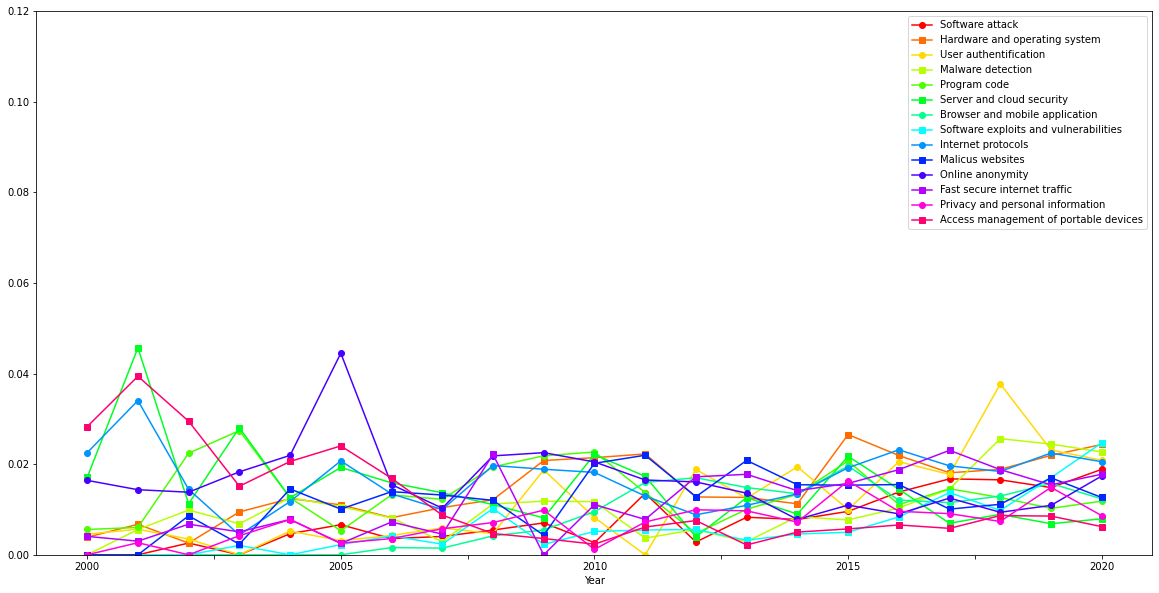

In [328]:
df_tec_perc_topic = df.copy()

perc = 0.2
a = 0
b = 0

for i in range(0,len(df_tec_perc_topic.index)):
    a = 0
    for j in range(0,14):
        if(j < 10):
            if (df_tec_perc_topic.at[i, 'Topic_0' + str(j)] >= perc ):
                a = 1
                continue
            else:
                df_tec_perc_topic.at[i, 'Topic_0' + str(j)] = 0
        else:
            if (df_tec_perc_topic.at[i, 'Topic_' + str(j)] >= perc ):
                a = 1
                continue
            else:
                df_tec_perc_topic.at[i, 'Topic_' + str(j)] = 0
    b += a
print(b, 'of', len(df_tec_perc_topic.index),'documents has a dominant topic over', perc)
            
df_tec_perc_topic = df_tec_perc_topic.groupby(['Year']).mean()

df_tec_perc_topic.columns = topicNames
plotGraph(df_tec_perc_topic)
df_tec_perc_topic
#plt.savefig('topicPlots/AllConfsAllTopics20%Significance.pdf')

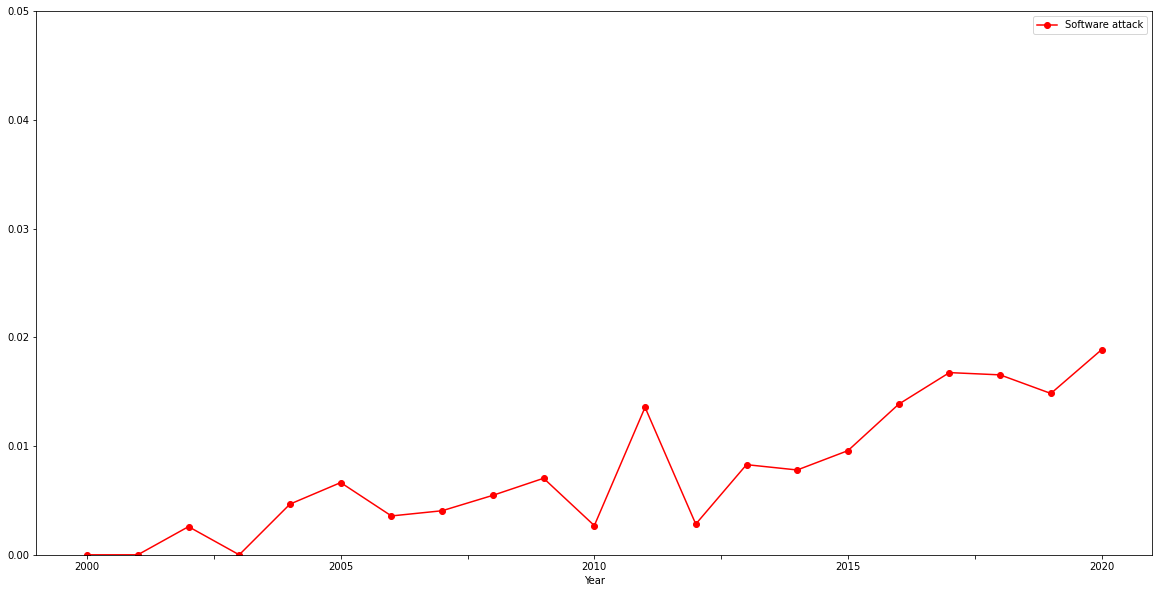

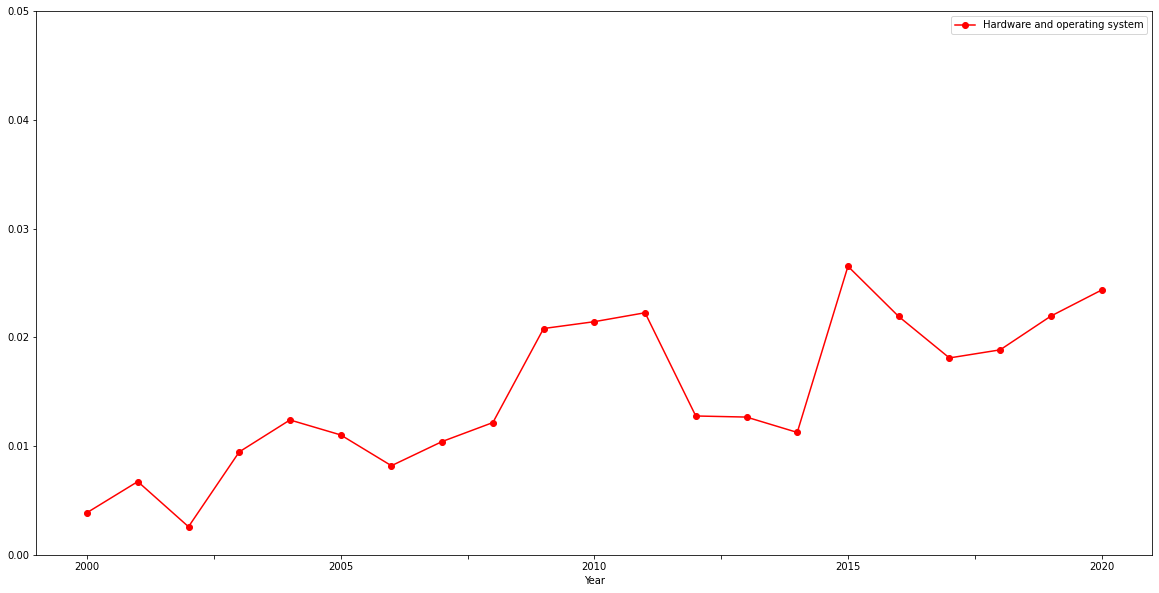

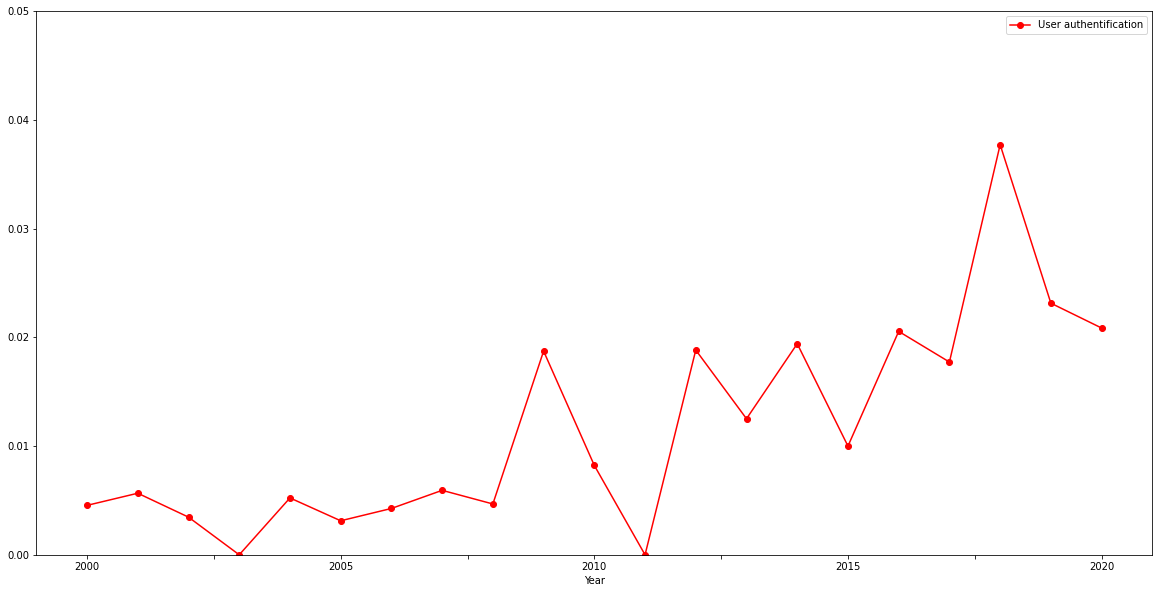

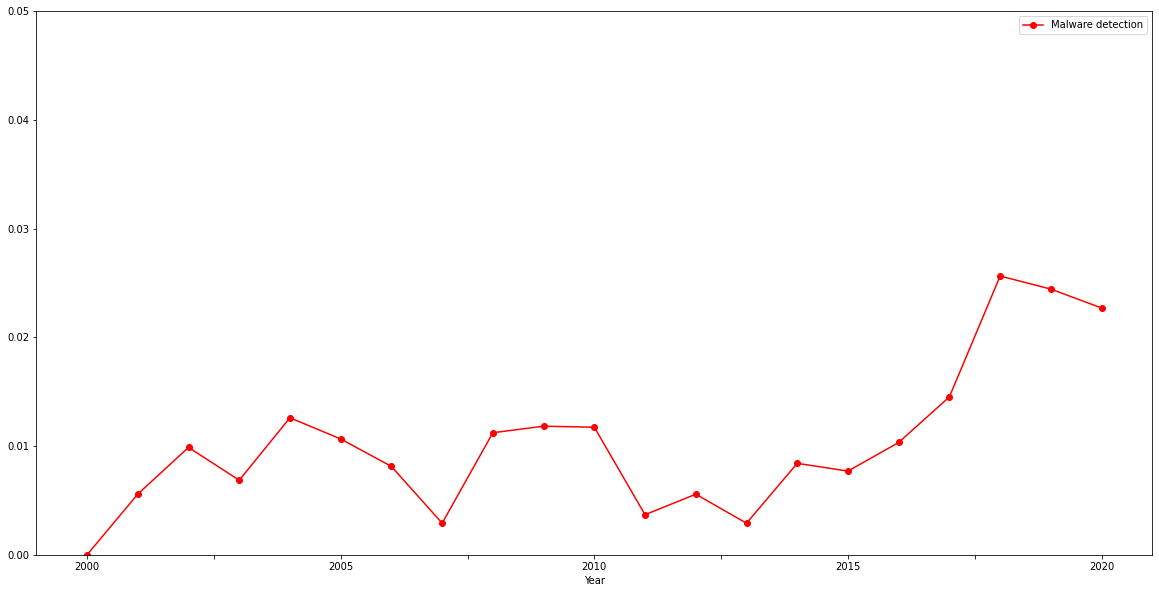

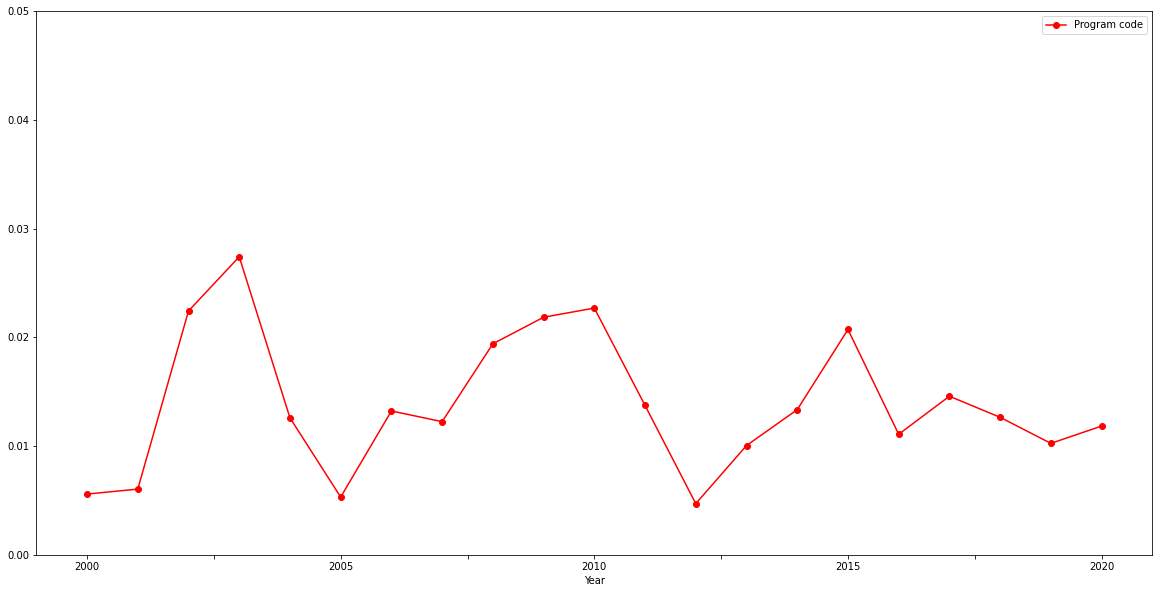

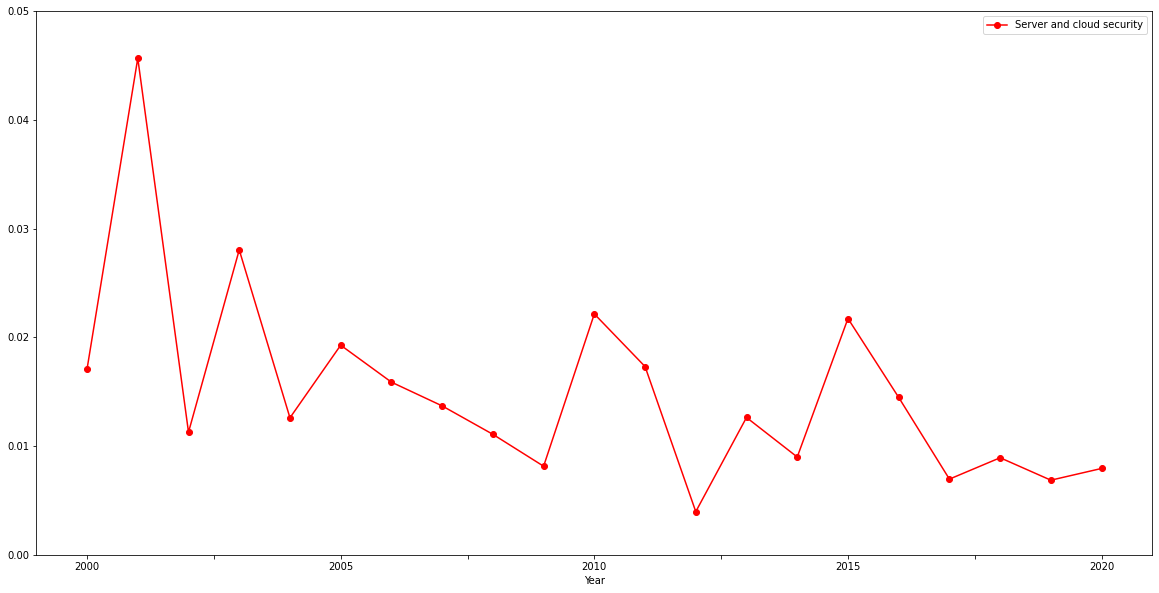

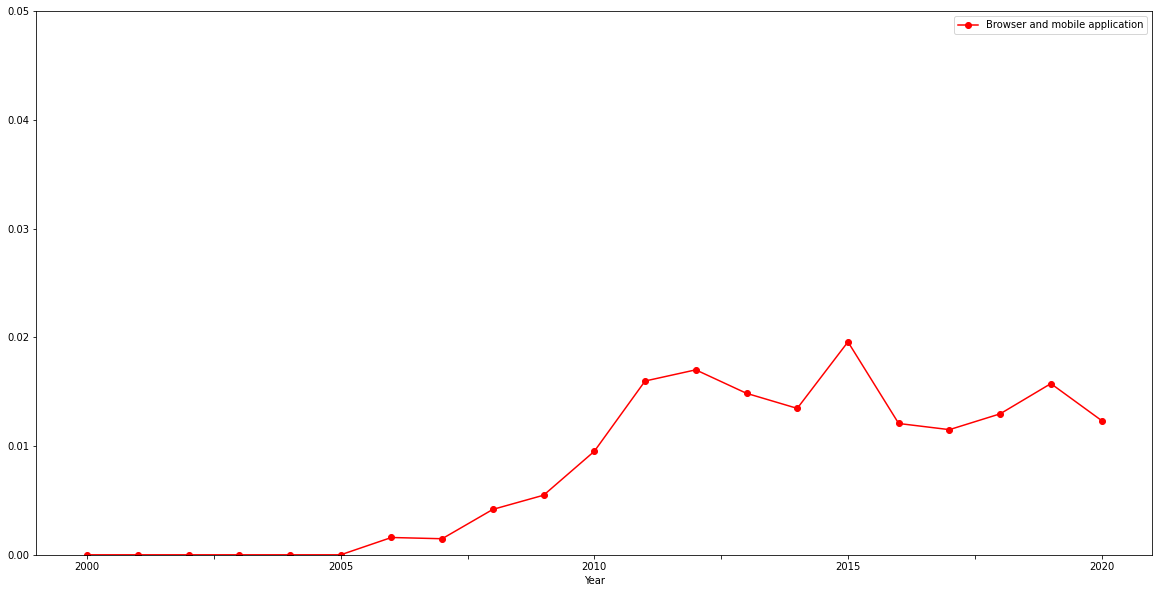

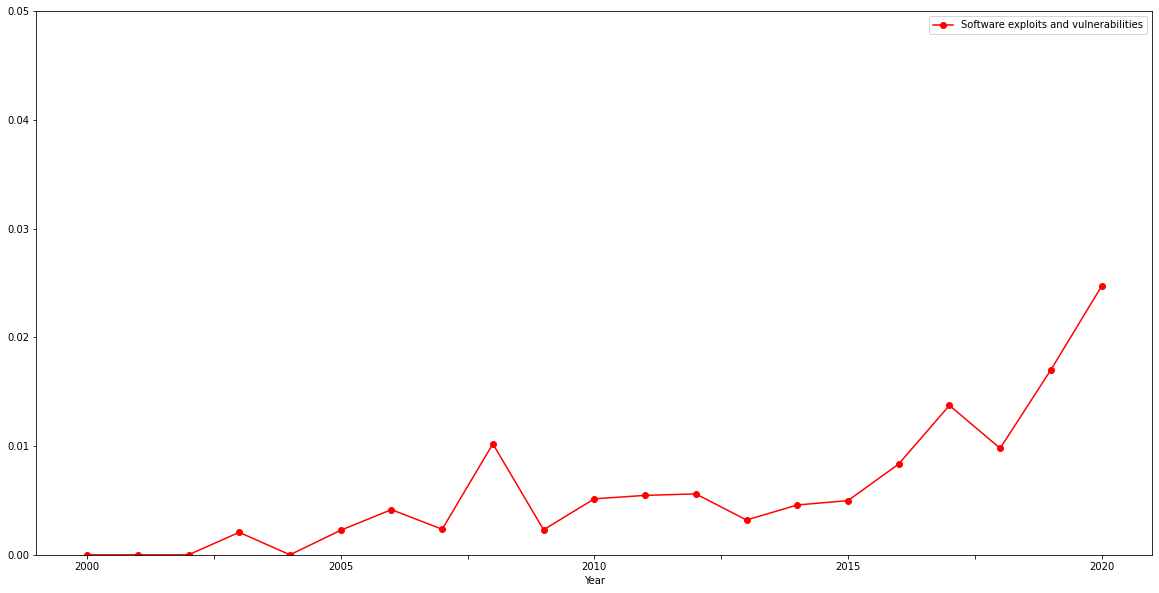

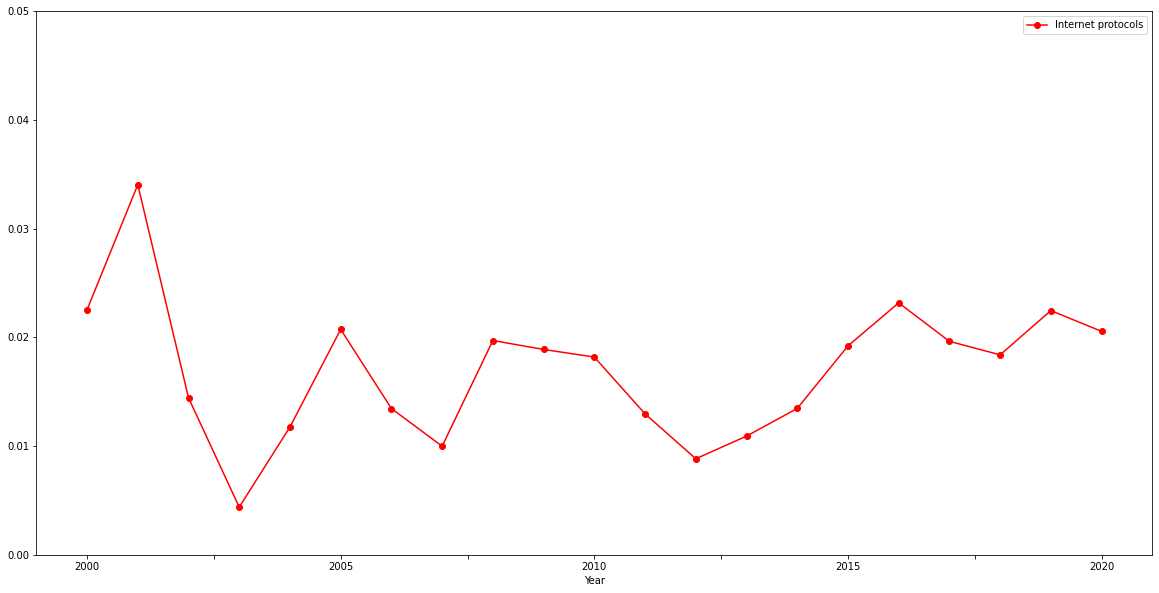

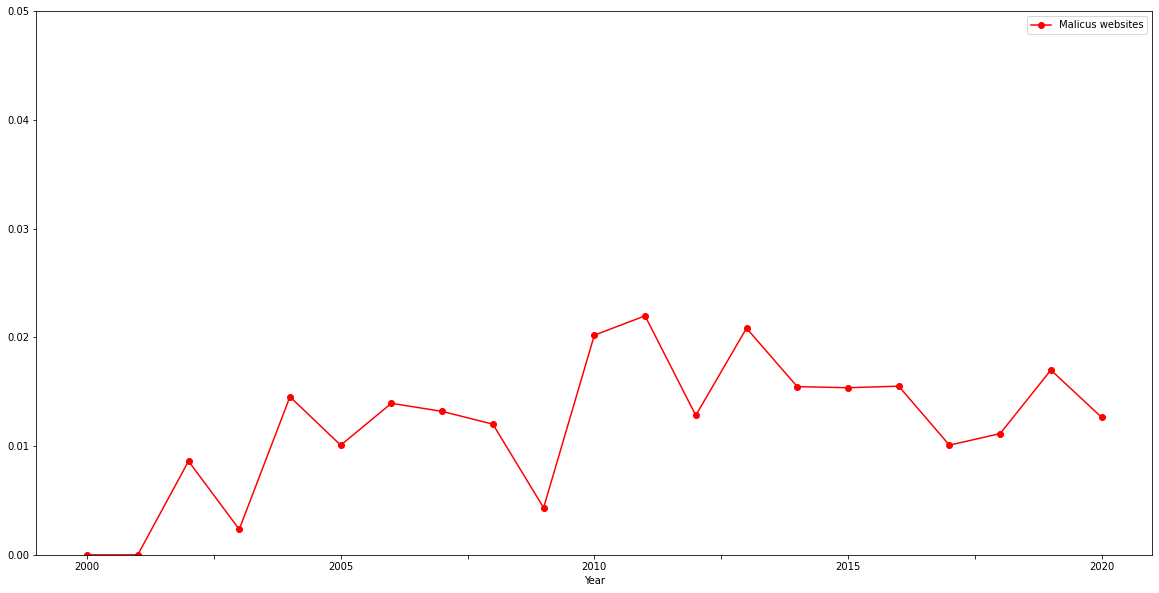

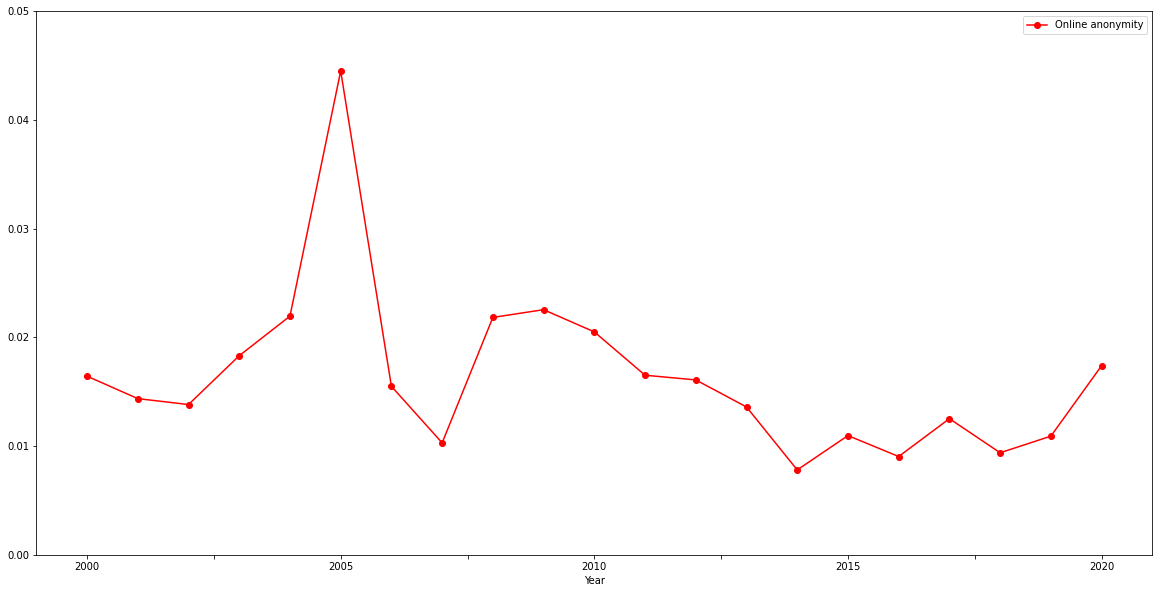

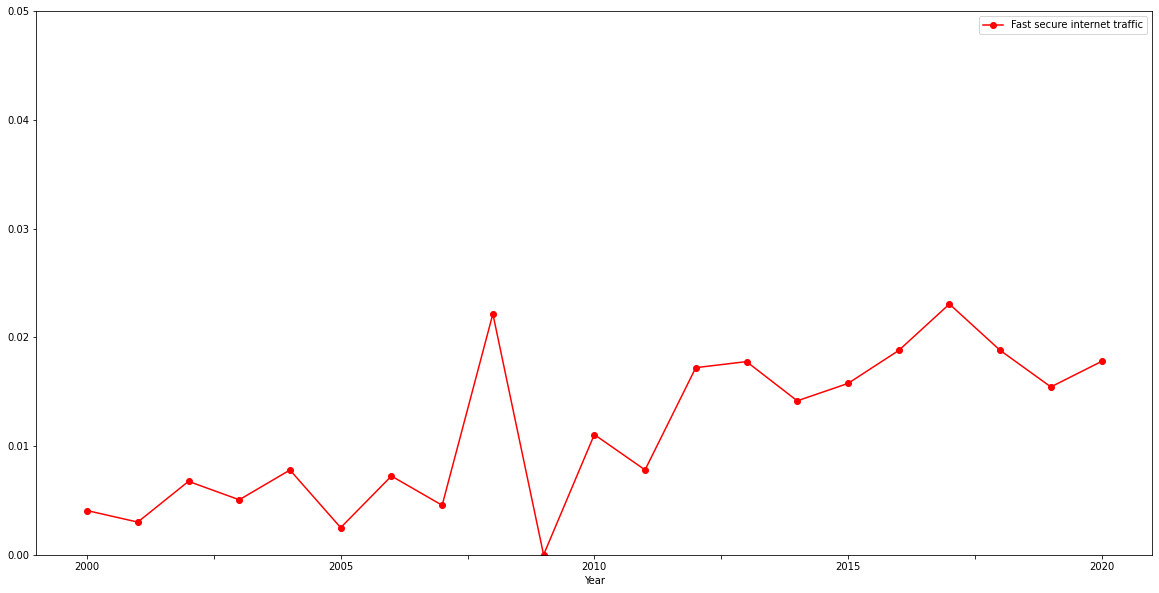

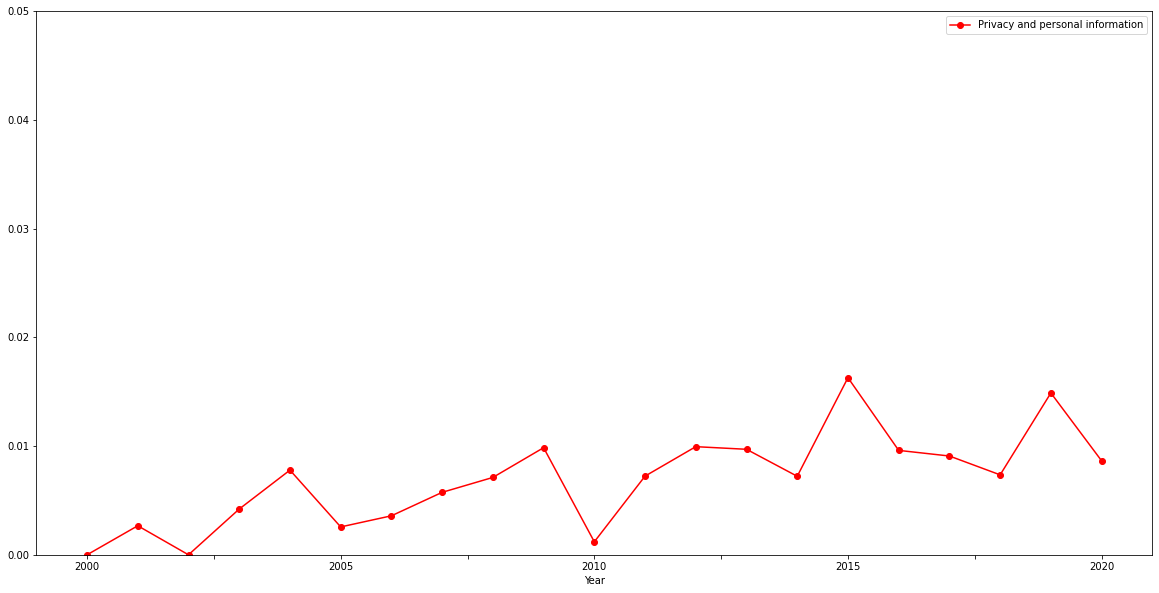

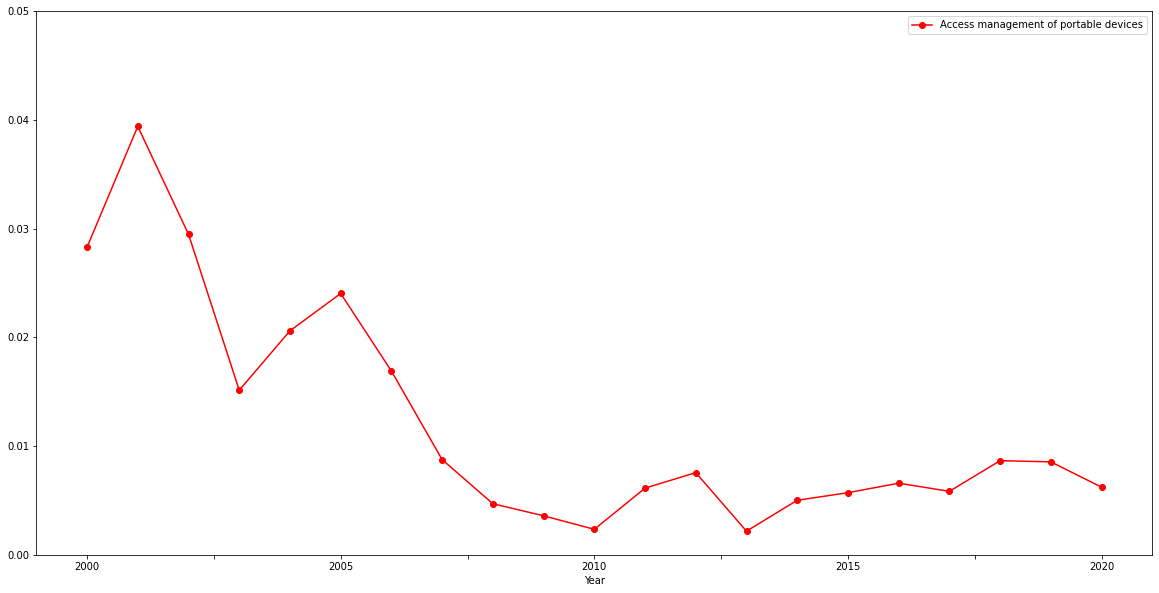

In [296]:
for i, topic in enumerate(topicNames):
    selectTopic = df_tec_perc_topic[[topic]]
    dfTopic = selectTopic.copy()
    plotGraph(dfTopic)
    #plt.savefig('topicPlots/20% significance Topic ' + str(i) + ' ' + topic + '.pdf')

## Plotting dominant topic distribution over years
Counts dominant topics for every year and plots it over all years

Software attack  Hardware and operating system  \
Conf   Year                                                   
CSS    2000         0.004999                       0.000000   
       2001         0.000000                       0.005167   
       2002         0.013523                       0.000000   
       2003         0.008784                       0.007067   
       2004         0.000000                       0.008787   
...                      ...                            ...   
Usenix 2016         0.027043                       0.029694   
       2017         0.029467                       0.038244   
       2018         0.021830                       0.024932   
       2019         0.022374                       0.029296   
       2020         0.023237                       0.036048   

             User authentification  Malware detection  Program code  \
Conf   Year                                                           
CSS    2000               0.010123           0.000000      0.007945   
       2001               0.007512           0.000000      0.006245   
       2002               0.011363           0.015880      0.008810   
       2003               0.000000           0.010871      0.036951   
       2004               0.000000           0.025379      0.011218   
...                            ...                ...           ...   
Usenix 2016               0.035468           0.009536      0.016894   
       2017               0.040619           0.011135      0.015790   
       2018               0.069170           0.017506      0.009046   
       2019               0.050428           0.010432      0.011851   
       2020               0.043965           0.023916      0.007783   

             Server and cloud security  Browser and mobile application  \
Conf   Year                                                              
CSS    2000                   0.029704                        0.000000   
       2001                   0.053433                        0.000000   
       2002                   0.017766                        0.000000   
       2003                   0.049858                        0.000000   
       2004                   0.019432                        0.000000   
...                                ...                             ...   
Usenix 2016                   0.014875                        0.017171   
       2017                   0.001357                        0.014701   
       2018                   0.004542                        0.018590   
       2019                   0.006164                        0.020568   
       2020                   0.005327                        0.011449   

             Software exploits and vulnerabilities  Internet protocols  \
Conf   Year                                                              
CSS    2000                               0.003382            0.046859   
       2001                               0.000000            0.095833   
       2002                               0.000000            0.044102   
       2003                               0.000000            0.015256   
       2004                               0.006060            0.033176   
...                                            ...                 ...   
Usenix 2016                               0.001898            0.006281   
       2017                               0.015915            0.011303   
       2018                               0.013317            0.013081   
       2019                               0.023015            0.006285   
       2020                               0.031020            0.009134   

             Malicus websites  Online anonymity  Fast secure internet traffic  \
Conf   Year                                                                     
CSS    2000          0.000000          0.013675                      0.017695   
       2001          0.000000          0.010955                      0.000000   
       2002        

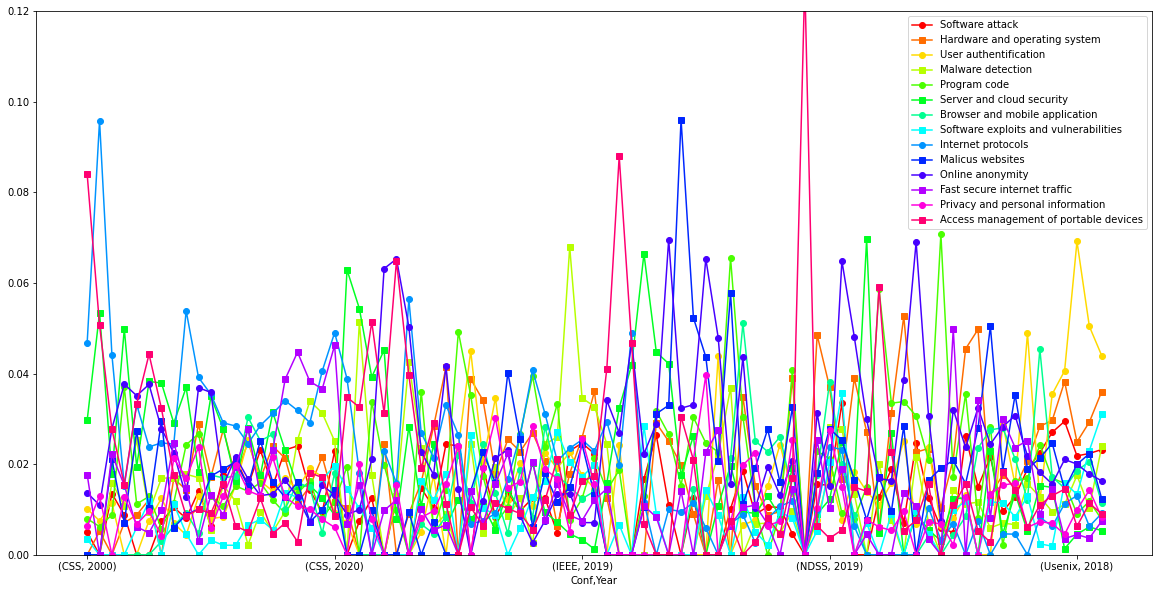

In [336]:
df_weight_dom_topics = df.copy()

for i in range(0,len(df_weight_dom_topics.index)):
    for j in range(0,10):
        if (df_weight_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_0' + str(j)):
            a = 0
            #df_weight_dom_topics.at[i, 'Topic_0' + str(j)] = 1
        else:
            df_weight_dom_topics.at[i, 'Topic_0' + str(j)] = 0
    for j in range(10,14):
        if (df_weight_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_' + str(j)):
            a = 0
            #df_weight_dom_topics.at[i, 'Topic_' + str(j)] = 1
        else:
            df_weight_dom_topics.at[i, 'Topic_' + str(j)] = 0


#df_weight_dom_topics = df_weight_dom_topics.groupby(['Year', 'Conf']).mean()
df_weight_dom_topics = df_weight_dom_topics.groupby(['Conf','Year']).mean()
df_weight_dom_topics.columns = topicNames
plotGraph(df_weight_dom_topics)
df_weight_dom_topics

#plt.savefig('topicPlots/dominant topic All Topics.pdf')

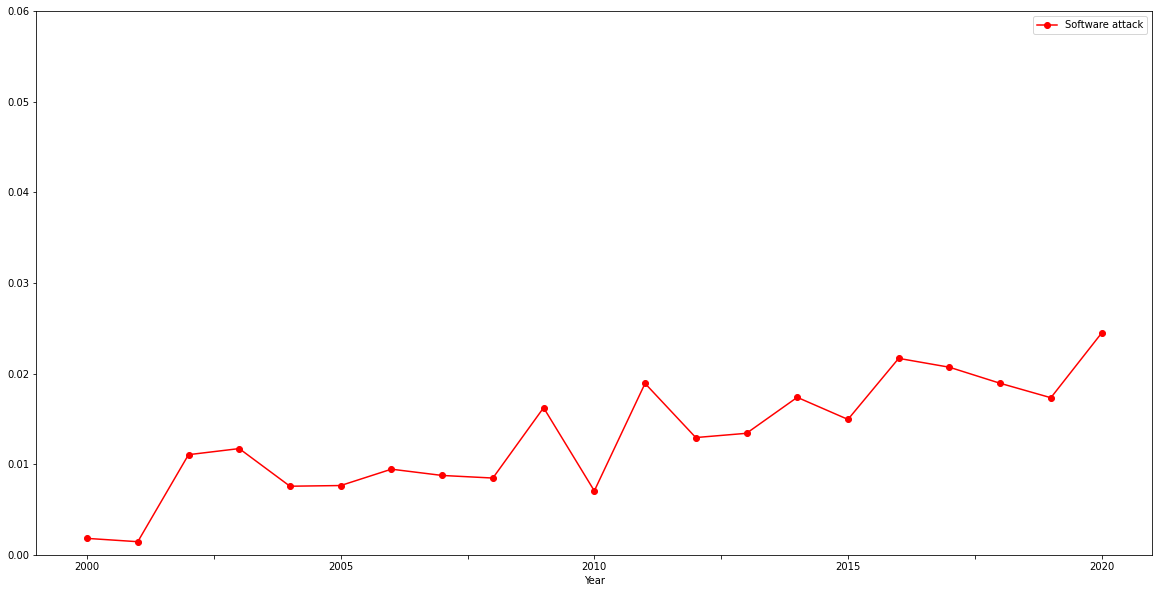

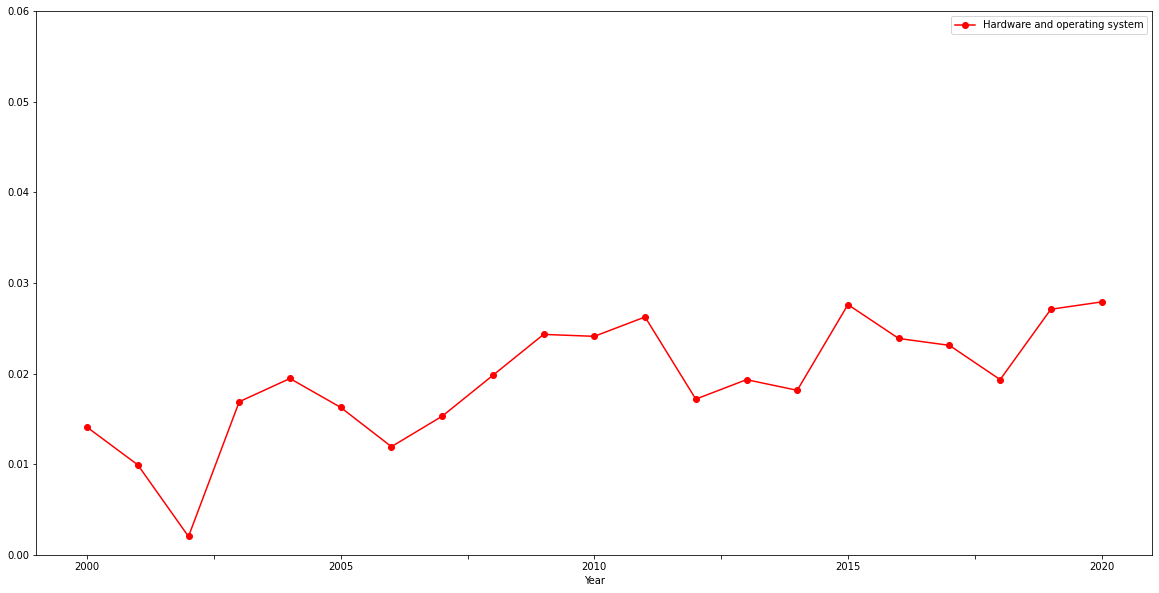

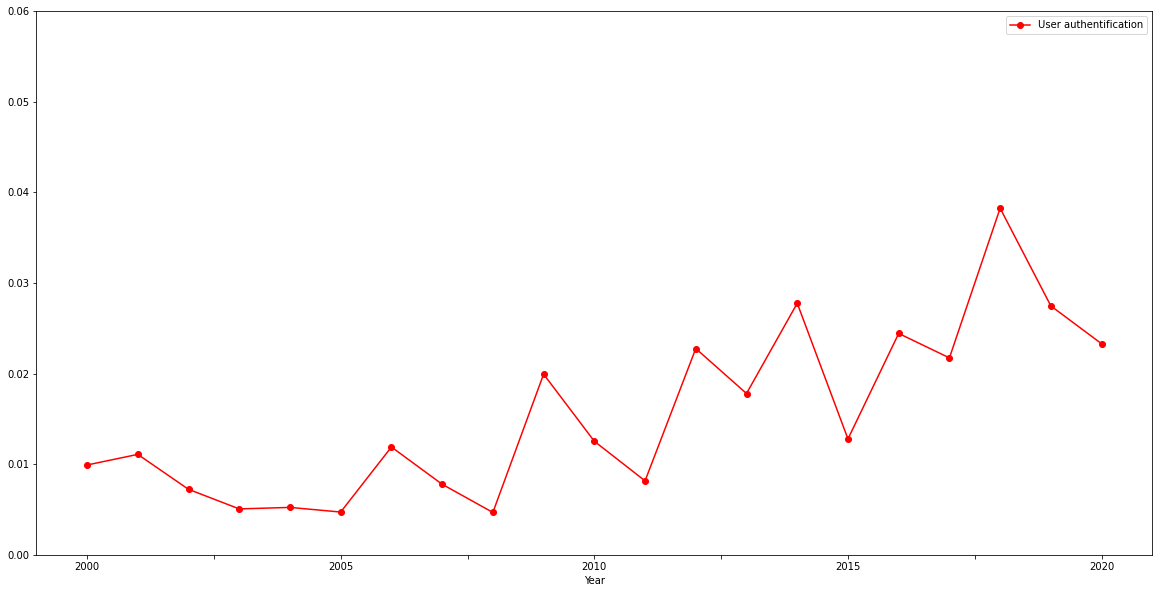

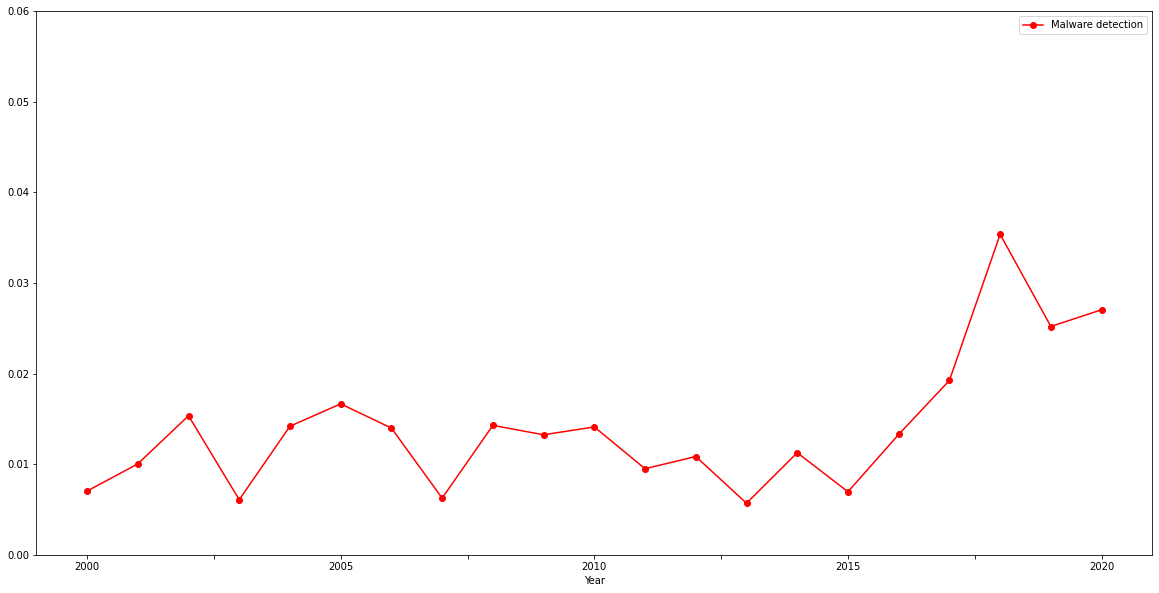

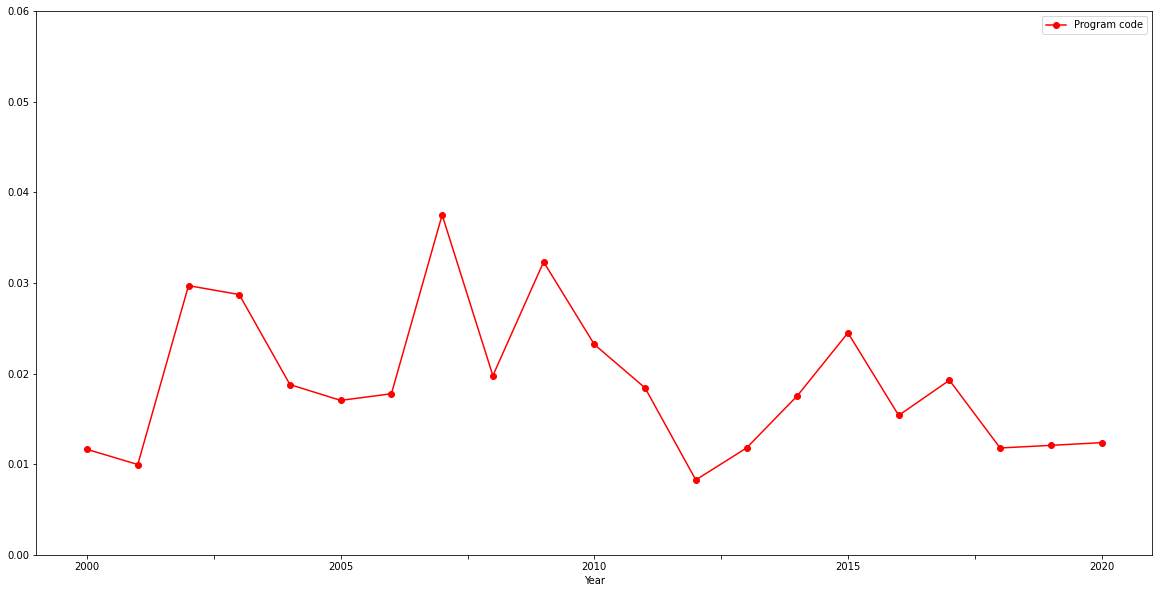

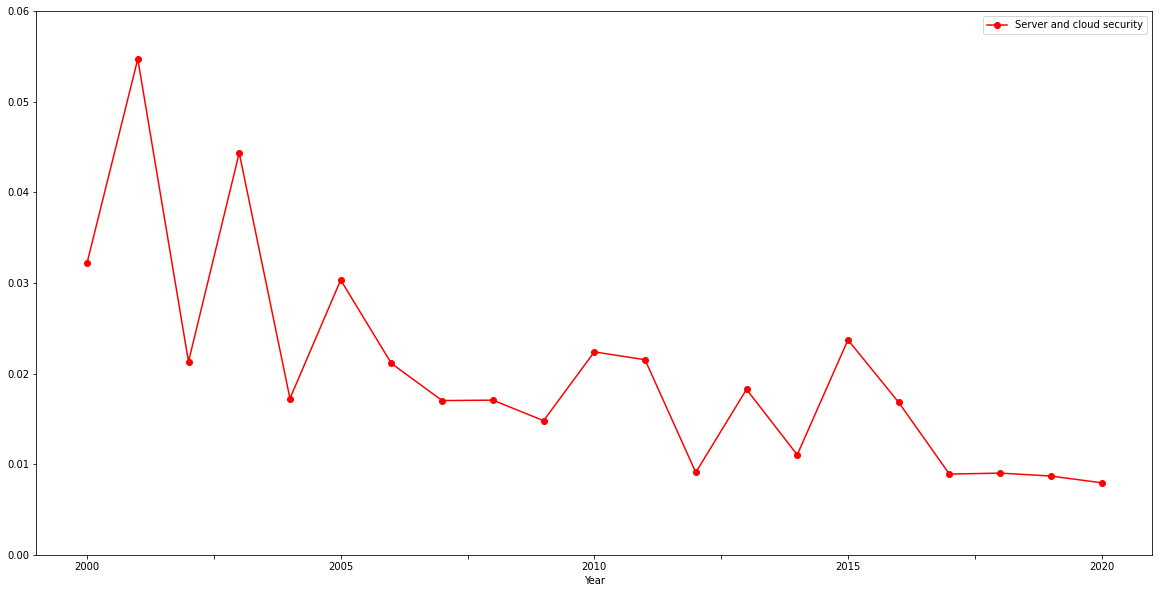

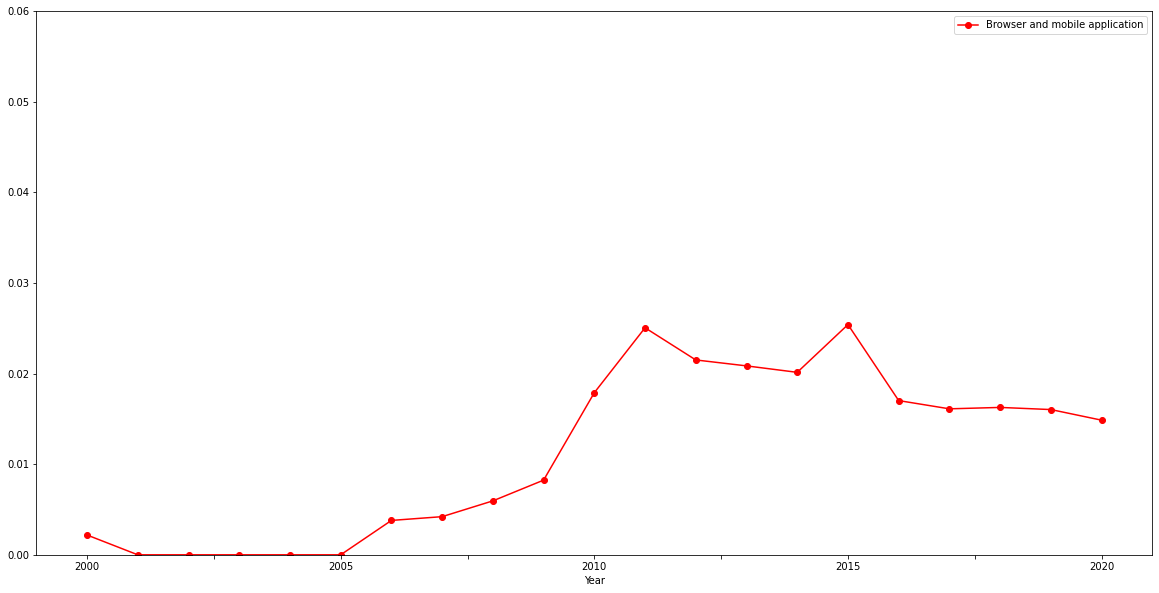

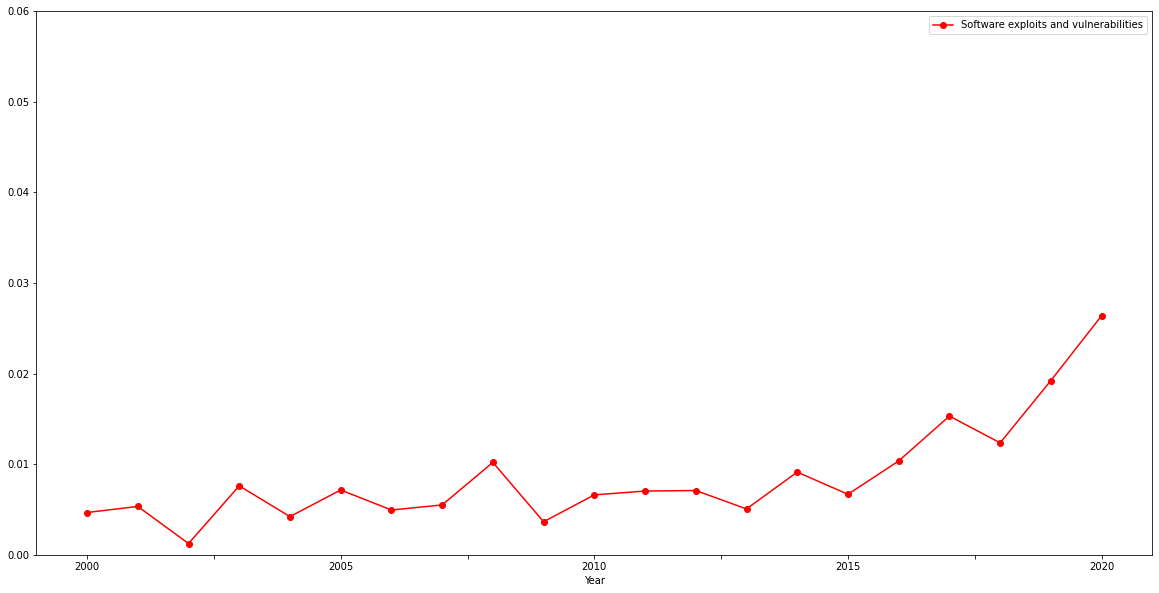

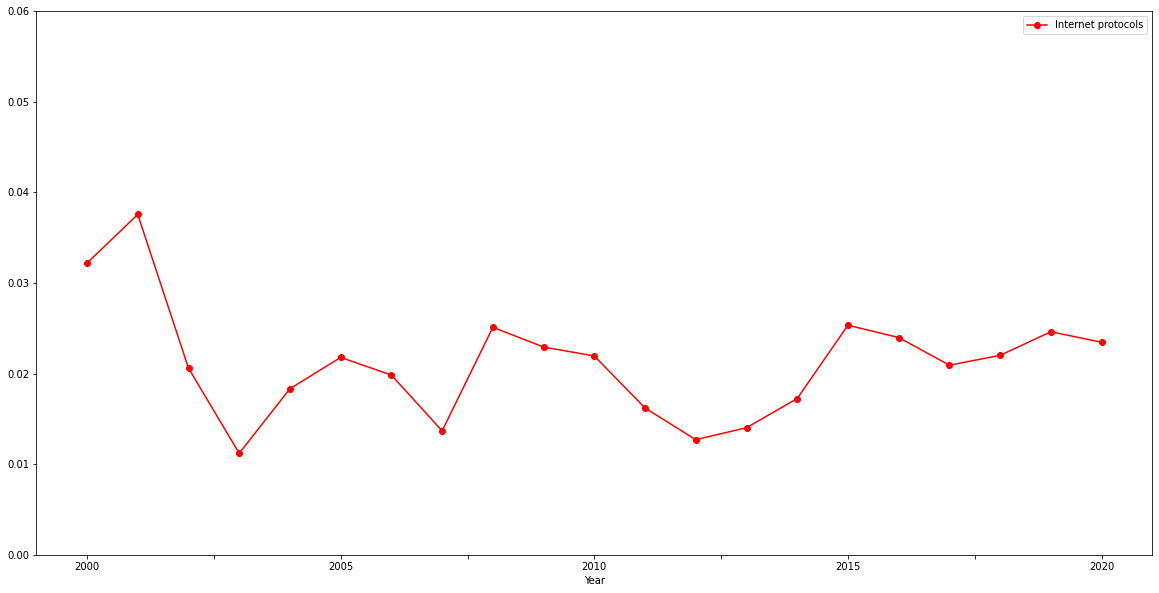

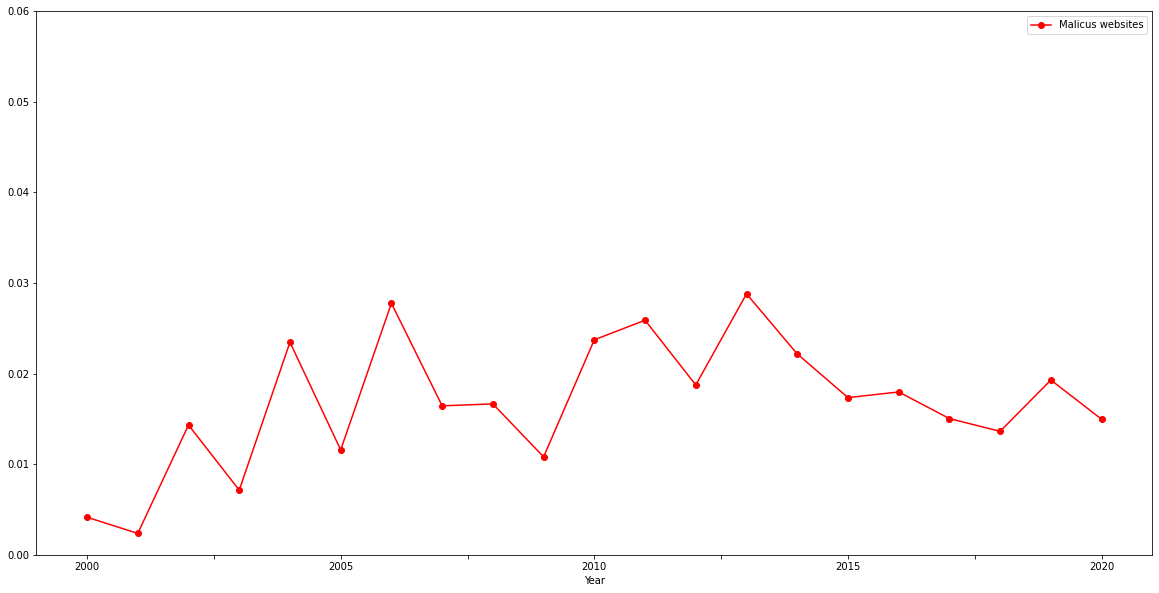

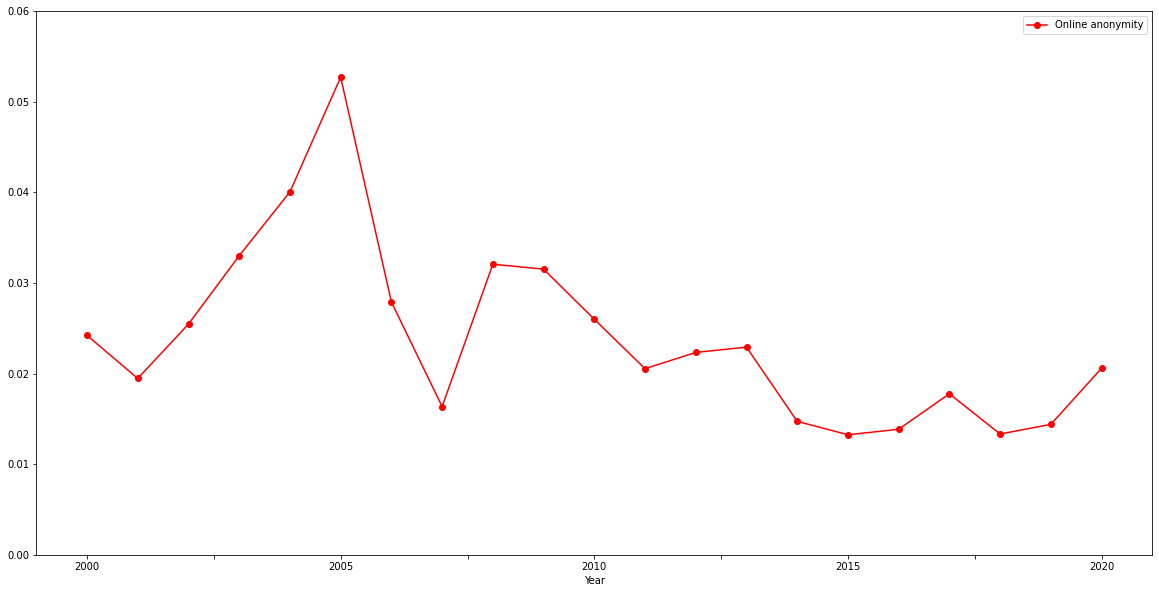

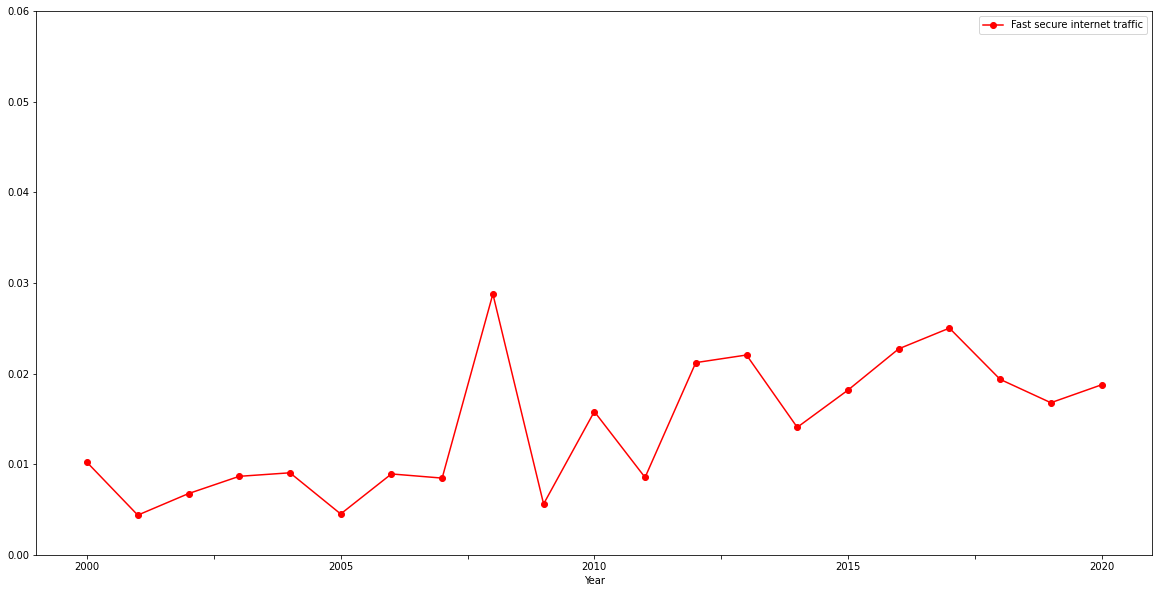

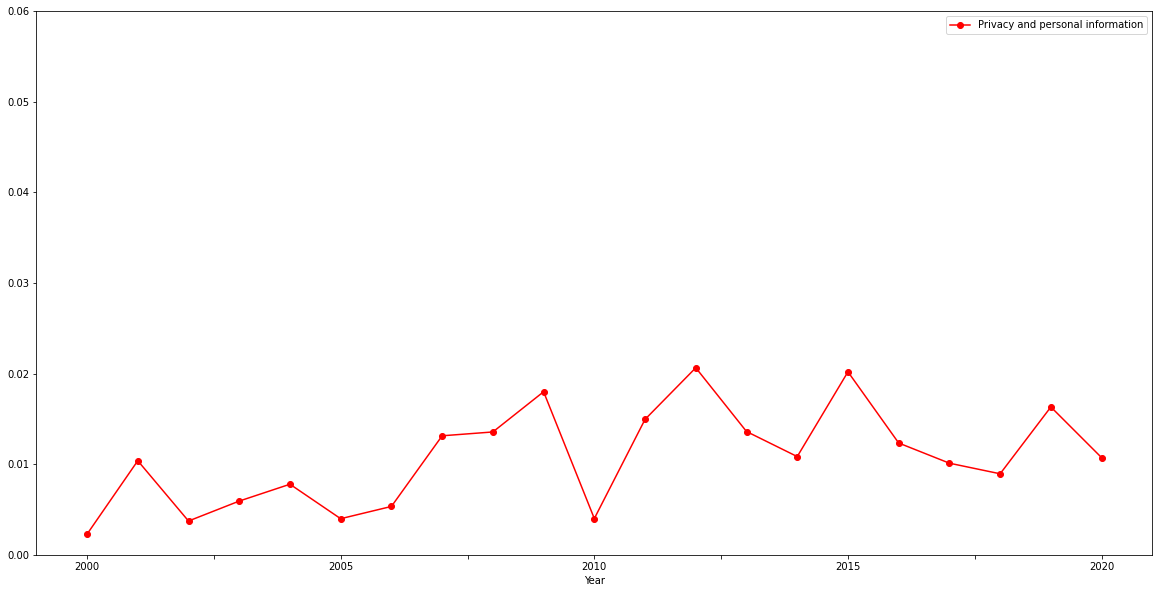

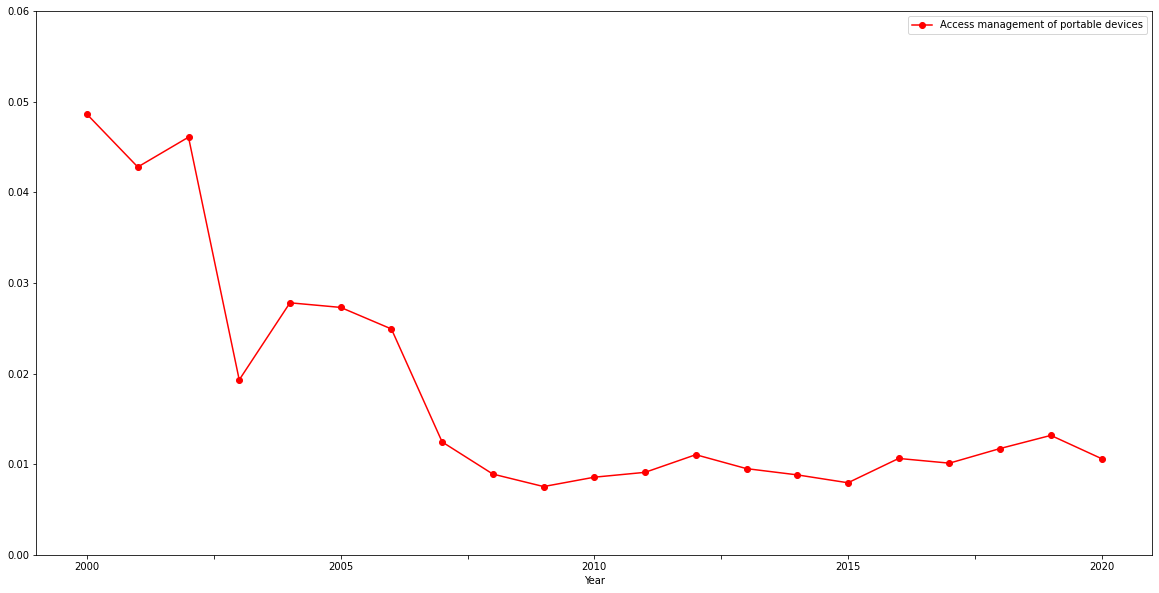

In [303]:
for i, topic in enumerate(topicNames):
    selectTopic = df_weight_dom_topics[[topicNames[i]]]
    dfTopic = selectTopic.copy()
    plotGraph(dfTopic)
    #plt.savefig('topicPlots/dominant topic Topic ' + str(i) + ' ' + topic + '.pdf')

,Software attack,Hardware and operating system,User authentification,Malware detection,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,
2000,0.012500,0.075000,0.050000,0.050000,0.062500,0.137500,0.012500,0.037500,0.137500,0.025000,0.112500,0.050000,0.012500,0.225000
2001,0.012195,0.048780,0.060976,0.048780,0.048780,0.231707,0.000000,0.036585,0.158537,0.012195,0.097561,0.024390,0.060976,0.158537
2002,0.060976,0.012195,0.036585,0.073171,0.134146,0.109756,0.000000,0.012195,0.109756,0.073171,0.121951,0.024390,0.024390,0.207317
2003,0.077670,0.087379,0.029126,0.029126,0.116505,0.203883,0.000000,0.048544,0.067961,0.038835,0.155340,0.038835,0.029126,0.077670
2004,0.037736,0.094340,0.018868,0.056604,0.084906,0.084906,0.000000,0.028302,0.084906,0.113208,0.207547,0.037736,0.028302,0.122642
2005,0.042553,0.074468,0.021277,0.074468,0.095745,0.138298,0.000000,0.042553,0.085106,0.042553,0.223404,0.021277,0.021277,0.117021
2006,0.051471,0.051471,0.066176,0.073529,0.080882,0.088235,0.022059,0.022059,0.080882,0.139706,0.132353,0.044118,0.029412,0.117647
2007,0.047619,0.065476,0.029762,0.029762,0.339286,0.077381,0.023810,0.023810,0.059524,0.059524,0.071429,0.041667,0.071429,0.059524
2008,0.035714,0.095238,0.017857,0.059524,0.083333,0.077381,0.029762,0.041667,0.107143,0.077381,0.136905,0.119048,0.071429,0.047619


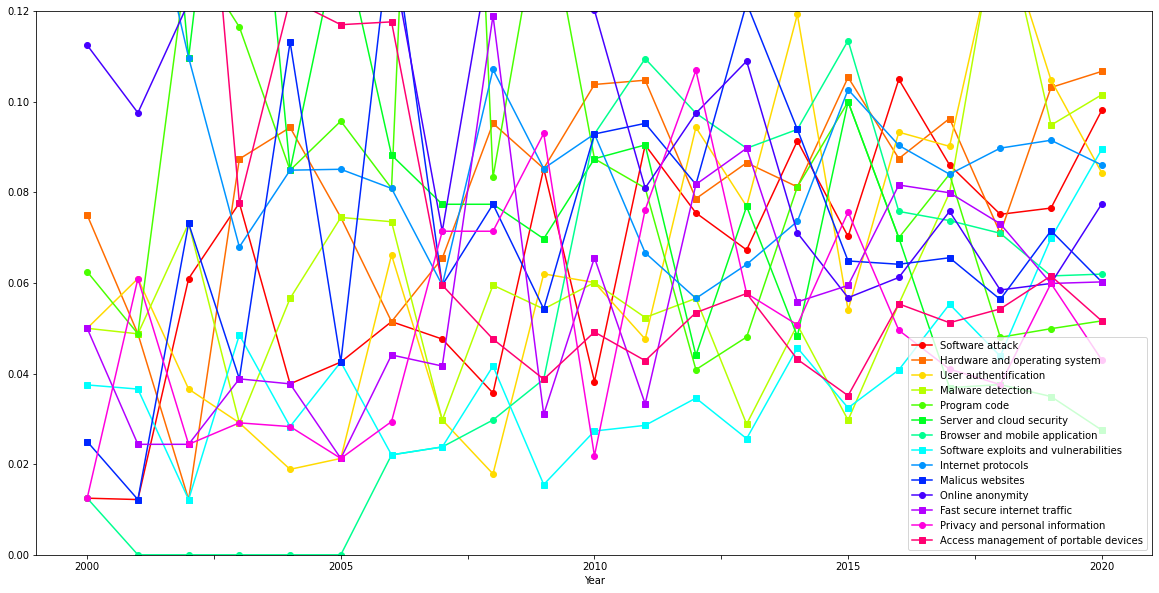

In [334]:
df_count_dom_topics = df.copy()

for i in range(0,len(df_count_dom_topics.index)):
    for j in range(0,10):
        if (df_count_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_0' + str(j)):
            df_count_dom_topics.at[i, 'Topic_0' + str(j)] = 1
        else:
            df_count_dom_topics.at[i, 'Topic_0' + str(j)] = 0

    for j in range(10,14):
        if (df_count_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_' + str(j)):
            df_count_dom_topics.at[i, 'Topic_' + str(j)] = 1
        else:
            df_count_dom_topics.at[i, 'Topic_' + str(j)] = 0            

#df_count_dom_topics = df_count_dom_topics.groupby(['Year', 'Conf']).sum()
df_count_dom_topics = df_count_dom_topics.groupby(['Year']).mean()
df_count_dom_topics.columns = topicNames
plotGraph(df_count_dom_topics)
df_count_dom_topics

In [319]:
df_dominant_topic_ = df.groupby(['Year', 'Dominant_Topic']).count()
df_dom_top = df_dominant_topic_[['Authors']]
df_dom_top.columns = ['Number_of_Abstracts']
df.to_csv('DF.csv')
#plotGraph(df_dom_top)
df_dom_top = df_dom_top.reset_index()
df_dom_top

#df_dom_top.to_csv(r'NumberOfAbstractsOfEveryYear.csv', index = False)

,Year,Dominant_Topic,Number_of_Abstracts
0,2000,Topic_00,1
1,2000,Topic_01,6
2,2000,Topic_02,4
3,2000,Topic_03,4
4,2000,Topic_04,5
...,...,...,...
284,2020,Topic_09,35
285,2020,Topic_10,45
286,2020,Topic_11,35
287,2020,Topic_12,25


## Plotting topic distribution over years

,Software attack,Hardware and operating system,User authentification,Detect malicus malware,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,
2000,0.053168,0.071660,0.065418,0.059491,0.070031,0.094920,0.058115,0.057034,0.093303,0.057934,0.081792,0.069431,0.064685,0.103018
2001,0.053562,0.065575,0.067757,0.059402,0.070553,0.116909,0.051358,0.055252,0.099897,0.056076,0.071806,0.069897,0.063662,0.098294
2002,0.064052,0.067986,0.062915,0.071515,0.082056,0.082309,0.054574,0.059440,0.086935,0.064123,0.083240,0.067580,0.057007,0.096267
2003,0.071194,0.072862,0.058201,0.066123,0.086207,0.096315,0.053807,0.063224,0.073705,0.060193,0.088741,0.070747,0.061146,0.077534
2004,0.062626,0.073961,0.063369,0.073948,0.073083,0.080132,0.050774,0.057987,0.074273,0.079815,0.088274,0.068133,0.068488,0.085136
2005,0.073405,0.072911,0.054477,0.070112,0.076343,0.082720,0.048694,0.061799,0.083347,0.066876,0.103213,0.065681,0.062638,0.077782
2006,0.068679,0.063562,0.065032,0.072783,0.073427,0.077994,0.057106,0.064251,0.076461,0.080640,0.084984,0.067292,0.065088,0.082700
2007,0.068960,0.072417,0.064195,0.067560,0.076199,0.082035,0.061376,0.064670,0.074864,0.074124,0.075652,0.071063,0.072842,0.074043
2008,0.065736,0.071781,0.061147,0.071692,0.076654,0.074373,0.058086,0.069423,0.074536,0.069484,0.083086,0.083860,0.068072,0.072071


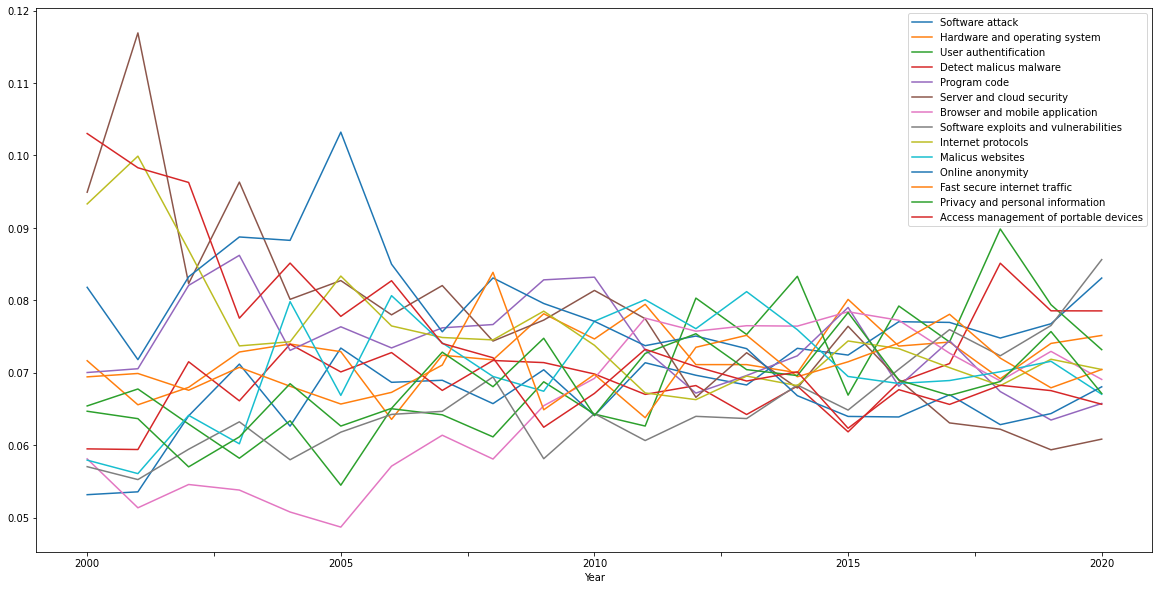

In [190]:
# Topic distribution over year graph
df_joined_year = df.copy()
df_joined_year = df_joined_year.groupby(['Year']).mean()
df_joined_year.columns = topicNames
#plotGraph(df_joined_year)
df_joined_year.plot(figsize=(20,10))
df_joined_year

# Graphs per conference of dominant topic

In [359]:
df_one_conf = df_weight_dom_topics.copy()
df_one_conf = df_one_conf.reset_index()

### CCS graph

,Conf,Software attack,Hardware and operating system,User authentification,Malware detection,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,,
2000,CSS,0.004999,0.000000,0.010123,0.000000,0.007945,0.029704,0.000000,0.003382,0.046859,0.000000,0.013675,0.017695,0.006280,0.083995
2001,CSS,0.000000,0.005167,0.007512,0.000000,0.006245,0.053433,0.000000,0.000000,0.095833,0.000000,0.010955,0.000000,0.013003,0.050740
2002,CSS,0.013523,0.000000,0.011363,0.015880,0.008810,0.017766,0.000000,0.000000,0.044102,0.021051,0.027873,0.022160,0.000000,0.027679
2003,CSS,0.008784,0.007067,0.000000,0.010871,0.036951,0.049858,0.000000,0.000000,0.015256,0.007093,0.037660,0.015332,0.012753,0.015517
2004,CSS,0.000000,0.008787,0.000000,0.025379,0.011218,0.019432,0.000000,0.006060,0.033176,0.027280,0.035127,0.006173,0.006770,0.033246
2005,CSS,0.000000,0.012188,0.007543,0.009456,0.012871,0.038265,0.000000,0.011814,0.023826,0.010221,0.037610,0.004845,0.009603,0.044269
2006,CSS,0.007366,0.000000,0.012472,0.016888,0.005787,0.037927,0.002973,0.000000,0.024701,0.029631,0.027844,0.009929,0.004156,0.032327
2007,CSS,0.010463,0.016844,0.006980,0.017031,0.011528,0.029103,0.006356,0.011230,0.024432,0.006025,0.022481,0.024772,0.021272,0.017576
2008,CSS,0.008034,0.014355,0.004354,0.017782,0.024277,0.036935,0.009302,0.004674,0.053870,0.008849,0.012770,0.014724,0.017051,0.008594


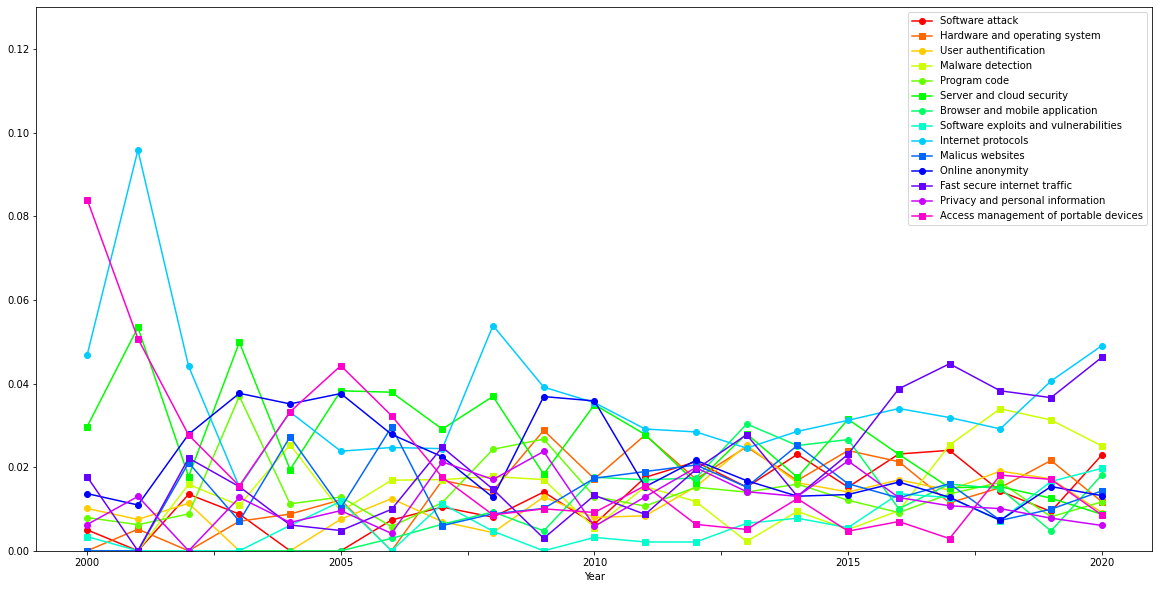

In [375]:
# Topic distribution over year graph for CSS
df_ccs = df_one_conf.copy()
df_ccs = df_ccs[df_ccs['Conf'] == 'CSS'].set_index('Year')

plotGraph(df_ccs)
#plt.savefig('topicPlots/CCS all dominant topic.pdf')
df_ccs


### IEEE graph

,Conf,Software attack,Hardware and operating system,User authentification,Malware detection,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,,
2000,IEEE,0.000000,0.010405,0.007142,0.000000,0.019489,0.062919,0.000000,0.014496,0.038890,0.000000,0.008878,0.006731,0.000000,0.034791
2001,IEEE,0.007408,0.000000,0.000000,0.051440,0.000000,0.054360,0.000000,0.010258,0.018167,0.000000,0.009976,0.015421,0.019975,0.032559
2002,IEEE,0.012493,0.000000,0.000000,0.017609,0.033809,0.039246,0.000000,0.005989,0.000000,0.009848,0.021101,0.000000,0.007839,0.051426
2003,IEEE,0.000000,0.024522,0.000000,0.000000,0.019785,0.045196,0.000000,0.000000,0.022977,0.000000,0.063174,0.009804,0.000000,0.031226
2004,IEEE,0.012442,0.000000,0.000000,0.013066,0.009924,0.007834,0.000000,0.000000,0.015777,0.000000,0.065314,0.012103,0.015345,0.064911
2005,IEEE,0.000000,0.009091,0.000000,0.042496,0.000000,0.028294,0.000000,0.000000,0.056365,0.009515,0.050327,0.000000,0.000000,0.039616
2006,IEEE,0.014719,0.015999,0.004969,0.023564,0.036037,0.010790,0.006764,0.016277,0.026870,0.000000,0.022751,0.010101,0.008231,0.019090
2007,IEEE,0.010417,0.028368,0.017496,0.006292,0.005888,0.024424,0.004655,0.012142,0.021462,0.007204,0.017685,0.005481,0.009700,0.028992
2008,IEEE,0.024395,0.041371,0.000000,0.008972,0.014350,0.006162,0.008453,0.017856,0.033061,0.000000,0.041607,0.006584,0.015606,0.011218


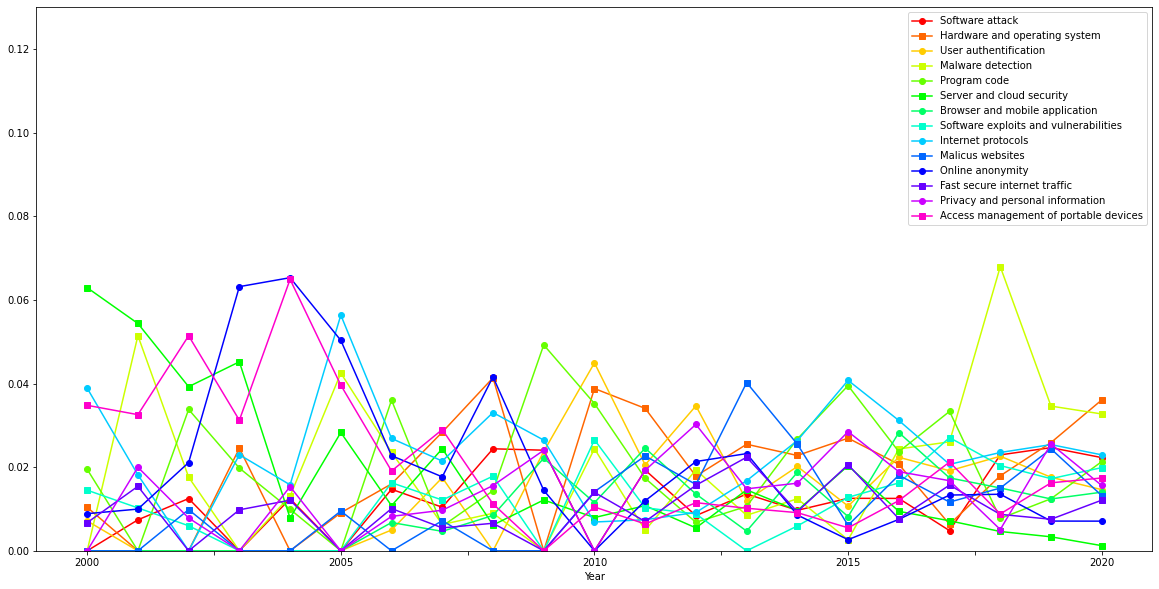

In [376]:
# Topic distribution over year graph for IEEE
df_ieee = df_one_conf.copy()
df_ieee = df_ieee[df_ieee['Conf'] == 'IEEE'].set_index('Year')

plotGraph(df_ieee)
#plt.savefig('topicPlots/IEEE all dominant topic.pdf')
df_ieee

### USENIX graph

,Conf,Software attack,Hardware and operating system,User authentification,Malware detection,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,,
2000,Usenix,0.000000,0.038967,0.018187,0.013454,0.008001,0.016527,0.008739,0.000000,0.006289,0.016583,0.048146,0.000000,0.000000,0.014976
2001,Usenix,0.000000,0.027192,0.013962,0.000000,0.014959,0.069667,0.000000,0.006955,0.000000,0.007752,0.029887,0.004495,0.007747,0.014001
2002,Usenix,0.012705,0.005917,0.011021,0.020072,0.058615,0.004819,0.000000,0.000000,0.000000,0.017172,0.016849,0.000000,0.006162,0.059035
2003,Usenix,0.018923,0.031332,0.015813,0.007783,0.033461,0.026842,0.000000,0.009114,0.000000,0.009588,0.016377,0.000000,0.005370,0.022770
2004,Usenix,0.007103,0.052647,0.025205,0.000000,0.033830,0.000000,0.000000,0.000000,0.000000,0.028391,0.038674,0.013643,0.009590,0.005349
2005,Usenix,0.024663,0.022670,0.006789,0.021588,0.030654,0.009207,0.000000,0.009635,0.000000,0.000000,0.069080,0.010672,0.000000,0.007581
2006,Usenix,0.012618,0.023456,0.023804,0.007162,0.020970,0.005472,0.004214,0.004587,0.010376,0.016441,0.030698,0.003475,0.007217,0.015611
2007,Usenix,0.005950,0.010364,0.006267,0.000000,0.070832,0.003117,0.000000,0.000000,0.003296,0.019105,0.007408,0.000000,0.006809,0.000000
2008,Usenix,0.004907,0.021036,0.008229,0.014324,0.017213,0.012295,0.004323,0.009833,0.006861,0.020848,0.032055,0.049858,0.002262,0.010912


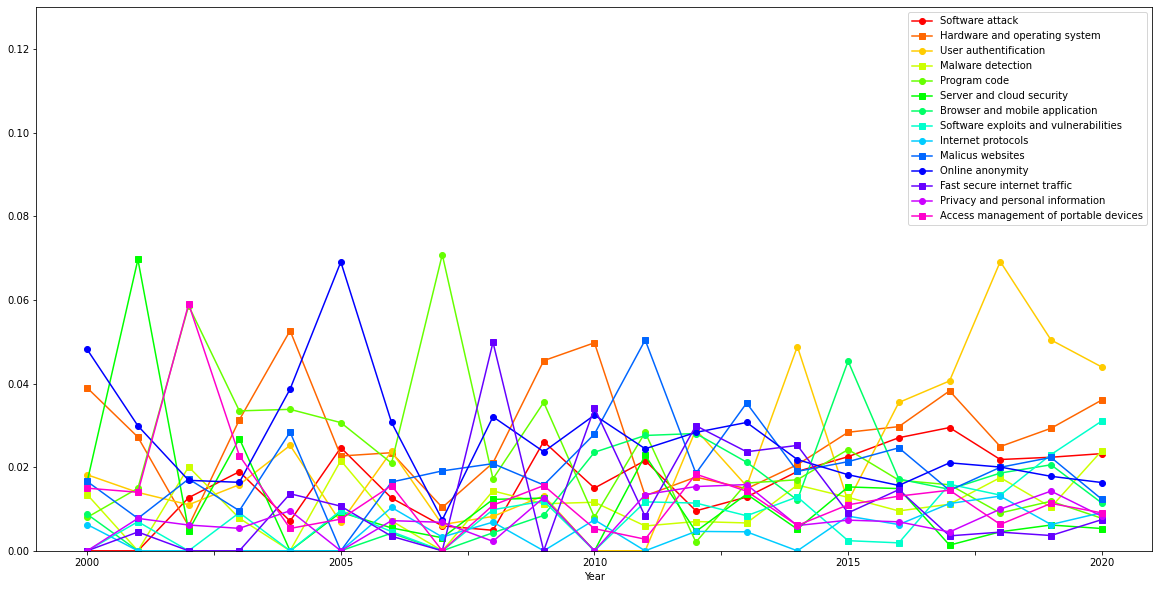

In [377]:
# Topic distribution over year graph for USENIX
df_usenix = df_one_conf.copy()
df_usenix = df_usenix[df_usenix['Conf'] == 'Usenix'].set_index('Year')

plotGraph(df_usenix)
#plt.savefig('topicPlots/USENIX all dominant topic.pdf')
df_usenix

### NDSS graph

,Conf,Software attack,Hardware and operating system,User authentification,Malware detection,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,,
2000,NDSS,0.000000,0.012481,0.000000,0.024457,0.014191,0.015798,0.000000,0.000000,0.029359,0.000000,0.034085,0.014593,0.000000,0.041075
2001,NDSS,0.000000,0.000000,0.024298,0.000000,0.018716,0.032469,0.000000,0.006636,0.019861,0.000000,0.026956,0.000000,0.000000,0.087979
2002,NDSS,0.000000,0.000000,0.000000,0.000000,0.000000,0.041807,0.000000,0.000000,0.048912,0.000000,0.046754,0.000000,0.000000,0.046732
2003,NDSS,0.016730,0.000000,0.000000,0.000000,0.013080,0.066461,0.000000,0.028427,0.011675,0.010454,0.022281,0.010862,0.000000,0.006847
2004,NDSS,0.026383,0.029074,0.000000,0.000000,0.031714,0.044731,0.000000,0.008982,0.000000,0.031142,0.028954,0.008295,0.000000,0.000000
2005,NDSS,0.010999,0.025049,0.000000,0.000000,0.026606,0.042192,0.000000,0.000000,0.010046,0.033007,0.069589,0.000000,0.000000,0.000000
2006,NDSS,0.000000,0.019837,0.000000,0.000000,0.015297,0.017563,0.000000,0.000000,0.009527,0.096057,0.032361,0.014101,0.000000,0.030485
2007,NDSS,0.012542,0.008916,0.000000,0.000000,0.030322,0.026249,0.014598,0.000000,0.011504,0.052323,0.033129,0.000000,0.021011,0.020912
2008,NDSS,0.000000,0.000000,0.000000,0.012921,0.024697,0.000000,0.000000,0.014366,0.005970,0.043677,0.065373,0.022642,0.039631,0.000000


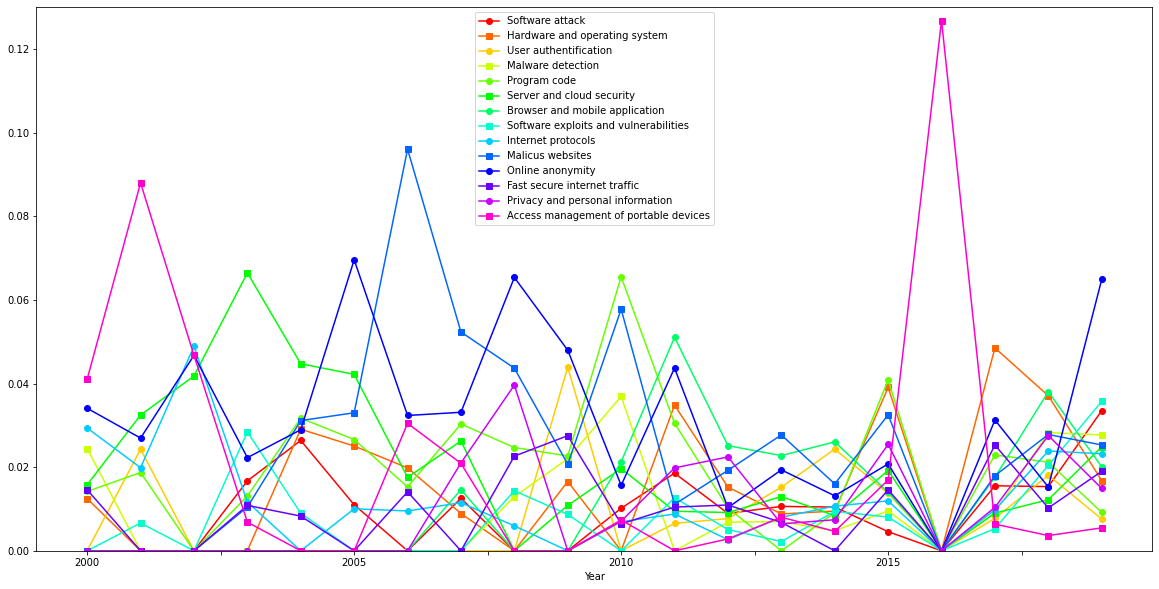

In [378]:
# Topic distribution over year graph for NDSS
df_ndss = df_one_conf.copy()
df_ndss = df_ndss[df_ndss['Conf'] == 'NDSS'].set_index('Year')

plotGraph(df_ndss)
#plt.savefig('topicPlots/NDSS all dominant topic.pdf')
df_ndss